# *** Choose your configuration: 0 docker, 1 cloudveneto ***

In [1]:
#0 Docker, 1 CloudVeneto
FIGHTER = 1

In [2]:
# la porta dove vedere i jobs --- METTERE LA PROPRIA QUI ---
SparkUI = 4041

# nicolò 4040
# marco  4041
# francesco 4042
# raffaele  4043

# MASTER 8080 E' PER TUTTI

<span style="font-size: 150%">Porta 8080, voce Running Applications: puoi vedere se qualcuno ci sta lavorando.
<br>
Porta 8080, voce Workers: vedresti core e memoria usata se c'è qualcun'altro.</span>

In [3]:
user = "user_a" # "user_a"  o  "user_b" (B SE SI E' I SECONDI A LAVORARCI)

In [4]:
core = 8 # 8 di 16, lasciare così se si lavora in due

Npartition = 8

# *** Remember to close Spark Session ***

In [47]:
spark.stop()

sudo pkill -u $(whoami) -f "jupyter-notebook"

<hr style="height:4px; background-color:black; border:none;" />

# Creation of the Spark Session and Context

In [5]:
# Standard libraries
import os
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# PySpark core
from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import StructType, StructField, IntegerType, TimestampType, BooleanType

# PySpark functions
from pyspark.sql.functions import (
    coalesce, corr,
    col, lit, expr, when, count, count_if, row_number, sum as spark_sum, abs as spark_abs,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg,
    first, last, lag, row_number, desc, asc, bool_or,
    explode, sequence, from_unixtime, to_date, unix_timestamp,
    window, min_by, mode, concat, monotonically_increasing_id
)

In [6]:
if FIGHTER==0:

    spark = SparkSession.builder \
        .master("spark://spark-master:7077") \
        .appName("ProjectDocker") \
        .config("spark.executor.memory", "1000m") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
        .getOrCreate()

        # SE NON FUNZIONA TOGLI I DUE CONFIG DI ARROW

        # .config("spark.executor.memory", "1500m")
        # .config("spark.executor.cores", "1")\
        # .config("spark.executor.instances", "12")\
        # .config("spark.cores.max", "12")\
        # .config("spark.default.parallelism", "24")\
        # .config("spark.sql.adaptive.enabled", "true")\

elif FIGHTER==1:

        os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
        os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"
        
        spark = SparkSession.builder \
            .appName("ProjectCloudVeneto") \
            .master("spark://10.67.22.135:7077") \
            .config("spark.scheduler.mode", "FAIR") \
            .config("spark.scheduler.pool", user) \
            .config("spark.scheduler.allocation.file", "file:///usr/local/spark/conf/fairscheduler.xml") \
            .config("spark.executor.memory", "2000m") \
            .config("spark.cores.max", core) \
            .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
            .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
            .config("spark.dynamicAllocation.enabled", "false") \
            .config("spark.shuffle.service.enabled", "false") \
            .config("spark.ui.port", SparkUI) \
            .getOrCreate()
    
else : print("Better choose an available fighter, you little bastard.")

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/17 09:58:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load directly df_final [ELIMINARE PRIMA DELLA CONSEGNA]

In [21]:
# hardware = "SW-088"
hardware = "SW-106"
# hardware = "SW-065"
# hardware = "SW-115"


# al 17 Ago 2025 13.00, se quello fatto finora è giusto in /mnt/shared/ ci sono salvati i df_final_anom solo di
# "SW-088" e "SW-106"
df_final_saved = spark.read.option("header", True).option("inferSchema", True).csv(f"/mnt/shared/df_final_{hardware}.csv")

In [22]:
df_final = df_final_saved.persist()
df_final.show(1)

[Stage 1968:============================>                           (4 + 4) / 8]

+-------+----------+---------+----+----+--------+---+-----+---+-----+-----+-----+---+-----+-----+-----+-----+-----+---+---+----+----+----+----+-----+----+-----+---+----+----+----+----+----+----+----+----+----+------+----+----+----+-----+-----+----+-----+----+----+-----+-----+---+----+----+-----+-----+-----+---+----+-----+----+-----+----+----+---+----+----+----+----+----+----+----+----+----+-------+----+----+---+---+------+------+------+------+------+------+---+-----+---+---+---+------+-----+-----+-----+---+---+---+-----+-----+---+---+---+---+---+---+---+---+-----+---+---+---+---+------+----+----+---+---+----+-----+-----+-----+---+-----+-----+-----+---+----+----+----+---+---+---+-------+---+---+---+---+---+-------------+-------------------+-------------------+----------+----------+------------+
|BlockID|     when1|window_id|  A5|  A9|ComError| P1|  P10|P15|  P16|  P17|  P18| P2|   P5|   P6|   P7|   P8|   P9| S1|S10|S100|S101|S102|S106| S107|S108| S109|S11|S110|S112|S113|S114|S115|S117|S

In [41]:
sensors = ['A5', 'A9', 'ComError', 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']
print(sensors)

['A5', 'A9', 'ComError', 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']


# Dataset upload and partition

### General Dataset

In [7]:
if FIGHTER==0:
    df = spark.read.option("header", True).option("inferSchema", True).csv("/ProvePreliminari/SW-106.csv")

elif FIGHTER==1:
    df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv")

else:
    print("Better choose an available fighter, you little bastard")

df = df.repartition(Npartition)

In [9]:
# inspect dataset
df.printSchema()

root
 |-- when: long (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: integer (nullable = true)



In [10]:
# inspect dataset
df.show(10, truncate=False)

+-------------+------+------+-----+
|when         |hwid  |metric|value|
+-------------+------+------+-----+
|1602247812642|SW-065|S100  |95   |
|1602544565258|SW-065|P7    |260  |
|1602899382279|SW-065|S9    |0    |
|1602124576237|SW-065|S143  |0    |
|1602959870262|SW-065|S49   |0    |
|1602532679018|SW-065|S100  |94   |
|1602119481602|SW-065|S137  |0    |
|1602270047321|SW-065|S50   |0    |
|1601843325781|SW-065|S106  |0    |
|1601750843738|SW-065|S110  |0    |
+-------------+------+------+-----+
only showing top 10 rows



### Focus on one hardware at time

In [8]:
# convert milliseconds into seconds
df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))

In [15]:
hwid_list = df.select("hwid").distinct()
hwid_list.show()

[Stage 8:==============>                                            (2 + 6) / 8]

+------+
|  hwid|
+------+
|SW-088|
|SW-106|
|SW-065|
|SW-115|
+------+



In [16]:
#df = df.persist()
df.show(1)

[Stage 12:===================================================>    (36 + 3) / 39]

+----------+------+------+-----+
|      when|  hwid|metric|value|
+----------+------+------+-----+
|1605443203|SW-065|   S50|    0|
+----------+------+------+-----+
only showing top 1 row



In [9]:
# CHANGE HERE HARDWARE TO ANALYZE
# hardware = "SW-088"
hardware = "SW-106" 
df_hw = df  .filter(col("hwid") == hardware)\
            .groupBy("when")\
            .pivot("metric")\
            .agg(first("value"))\
            .withColumn("time", from_unixtime(col("when")))\
            .orderBy("when")

# momentarily persist this dataframe, then we'll unpersist
df_hw = df_hw.persist()

# we trigger persist transformation
df_hw.count()

25/08/17 09:59:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

639869

In [105]:
df_hw.printSchema()

root
 |-- when: integer (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- ComError: integer (nullable = true)
 |-- P1: integer (nullable = true)
 |-- P10: integer (nullable = true)
 |-- P15: integer (nullable = true)
 |-- P16: integer (nullable = true)
 |-- P17: integer (nullable = true)
 |-- P18: integer (nullable = true)
 |-- P2: integer (nullable = true)
 |-- P5: integer (nullable = true)
 |-- P6: integer (nullable = true)
 |-- P7: integer (nullable = true)
 |-- P8: integer (nullable = true)
 |-- P9: integer (nullable = true)
 |-- S1: integer (nullable = true)
 |-- S10: integer (nullable = true)
 |-- S100: integer (nullable = true)
 |-- S101: integer (nullable = true)
 |-- S102: integer (nullable = true)
 |-- S106: integer (nullable = true)
 |-- S107: integer (nullable = true)
 |-- S108: integer (nullable = true)
 |-- S109: integer (nullable = true)
 |-- S11: integer (nullable = true)
 |-- S110: integer (nullable = true)
 |-- S112: integer 

In [18]:
# Get sensors list

excluded_columns = {"when", "time"}

sensors = [field.name for field in df_hw.schema.fields 
           if field.name not in excluded_columns]

print(sensors)

['A5', 'A9', 'ComError', 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']


In [17]:
selected_cols = ["when", "time", "S117", "S118", "S169", "S170"]

In [19]:
# show first 5 rows
df_hw.select(*selected_cols).orderBy(col("time").asc()).show(5)

+----------+-------------------+----+----+----+----+
|      when|               time|S117|S118|S169|S170|
+----------+-------------------+----+----+----+----+
|1601510422|2020-10-01 00:00:22|   0|   1|NULL|NULL|
|1601510425|2020-10-01 00:00:25|NULL|NULL|   0|   1|
|1601510453|2020-10-01 00:00:53|   0|   1|NULL|NULL|
|1601510455|2020-10-01 00:00:55|NULL|NULL|   0|   1|
|1601510483|2020-10-01 00:01:23|   0|   1|NULL|NULL|
+----------+-------------------+----+----+----+----+
only showing top 5 rows



In [20]:
# show last 5 rows
df_hw.select(*selected_cols).orderBy(col("time").desc()).limit(5).orderBy(col("time").asc()).show()

+----------+-------------------+----+----+----+----+
|      when|               time|S117|S118|S169|S170|
+----------+-------------------+----+----+----+----+
|1616830056|2021-03-27 07:27:36|NULL|NULL|   0|   0|
|1616830083|2021-03-27 07:28:03|   1|   0|NULL|NULL|
|1616830086|2021-03-27 07:28:06|NULL|NULL|   0|   0|
|1616830114|2021-03-27 07:28:34|   0|   0|NULL|NULL|
|1616830117|2021-03-27 07:28:37|NULL|NULL|   0|   0|
+----------+-------------------+----+----+----+----+



Usefull function to inspect a general dataframe

In [11]:
def inspect(df: DataFrame, sensors: list, start: int, end: int) -> DataFrame:
    """
    Filter a DataFrame by time range and select specified sensor columns.

    Args:
        df:        Input Spark DataFrame with 'when' and 'time' columns.
        sensors:   List of sensor column names to include (e.g., ['S117', 'S118']).
        start:  Start of the time range (Unix timestamp, in seconds).
        end:    End of the time range (Unix timestamp, in seconds).

    Returns:
        Filtered Spark DataFrame with columns ['time', 'when', ...sensors].
    """
    selected_columns = ['when'] + sensors

    return (
        df.select(*selected_columns)
          .filter((col("when") >= start) & (col("when") <= end)) \
          .withColumn("time", from_unixtime(col("when")))
    )

In [20]:
inspect(df_hw, sensors=["S117"], start=1601526622, end=1601531000).show(10)

+----------+----+-------------------+
|      when|S117|               time|
+----------+----+-------------------+
|1601526676|   0|2020-10-01 04:31:16|
|1601526679|NULL|2020-10-01 04:31:19|
|1601526736|   0|2020-10-01 04:32:16|
|1601526739|NULL|2020-10-01 04:32:19|
|1601526796|   0|2020-10-01 04:33:16|
|1601526799|NULL|2020-10-01 04:33:19|
|1601526857|   0|2020-10-01 04:34:17|
|1601526860|NULL|2020-10-01 04:34:20|
|1601526917|   0|2020-10-01 04:35:17|
|1601526920|NULL|2020-10-01 04:35:20|
+----------+----+-------------------+
only showing top 10 rows



# Timestamp analysis

In [134]:
def compute_time_differences(df, when_col="when", max_collect=1_000_000):
    """
    Computes time differences (Δwhen) between consecutive rows in a DataFrame.

    Args:
        df (DataFrame): Spark DataFrame with a time column (e.g., 'when').
        when_col (str): Name of the time column to compute differences on.
        max_collect (int): Threshold to safely collect diffs to driver.

    Returns:
        rdd_diff (RDD): RDD of differences (current - previous).
    """
    rdd_times = df.select(when_col).rdd.map(lambda row: row[when_col])
    rdd_shifted = rdd_times.zipWithIndex().map(lambda x: (x[1], x[0]))  # (index, time)
    rdd_prev = rdd_shifted.map(lambda x: (x[0] + 1, x[1]))              # shift by +1 index
    rdd_joined = rdd_shifted.join(rdd_prev).sortByKey()
    rdd_diff = rdd_joined.map(lambda x: x[1][0] - x[1][1])

    num_diffs = rdd_diff.count()
    print(f"Number of time differences: {num_diffs}")

    if num_diffs < max_collect:
        return rdd_diff
    else:
        print("Too many differences to collect safely.")
        return None

In [20]:
def time_diff_summary(rdd_diff, spark, top_n=5):
    """
    Summarizes the RDD of time differences into a frequency table and prints top/bottom values.

    Args:
        rdd_diff (RDD): RDD of integer time differences.
        spark (SparkSession): Active Spark session.
        top_n (int): Number of rows to show from top and bottom.

    Returns:
        df_freq (DataFrame): DataFrame with columns ['diff', 'count'].
    """
    if rdd_diff is None:
        print("No differences available to summarize.")
        return None

    df_freq = rdd_diff.map(lambda d: (d, 1)) \
                      .reduceByKey(lambda a, b: a + b) \
                      .toDF(["diff", "count"]) \
                      .orderBy("diff")

    print(f"\n{top_n} smallest time differences:")
    df_freq.show(top_n, truncate=False)

    print(f"\n{top_n} largest time differences:")
    df_freq.orderBy("diff", ascending=False).show(top_n, truncate=False)

    return df_freq

In [21]:
# Compute time differences
rdd_diff = compute_time_differences(df_hw)

# Summarize and print top/bottom time gaps
df_diff_summary = time_diff_summary(rdd_diff, spark)

Number of time differences: 398038



5 smallest time differences:


+----+------+
|diff|count |
+----+------+
|2   |23809 |
|3   |166233|
|4   |5106  |
|5   |464   |
|6   |298   |
+----+------+
only showing top 5 rows


5 largest time differences:


[Stage 100:===================================================> (392 + 8) / 400]

+-------+-----+
|diff   |count|
+-------+-----+
|5003774|1    |
|2066908|1    |
|757864 |1    |
|48451  |1    |
|28598  |1    |
+-------+-----+
only showing top 5 rows



In [26]:
def plot_diff_histogram(differences, min_diff, max_diff, delta):
    
    filtered = [d for d in differences if min_diff <= d <= max_diff]

    bins = int((max_diff - min_diff) / delta)

    plt.figure(figsize=(10, 6))
    plt.hist(filtered, bins=bins, color="steelblue", edgecolor="black")
    plt.title(f"Time Difference Events (range {min_diff} - {max_diff} [s])")
    plt.xlabel("Time difference [s]")
    plt.ylabel("Counts")
    #plt.grid(True)
    plt.show()

In [27]:
diffs = rdd_diff.collect() # check previously the dimension

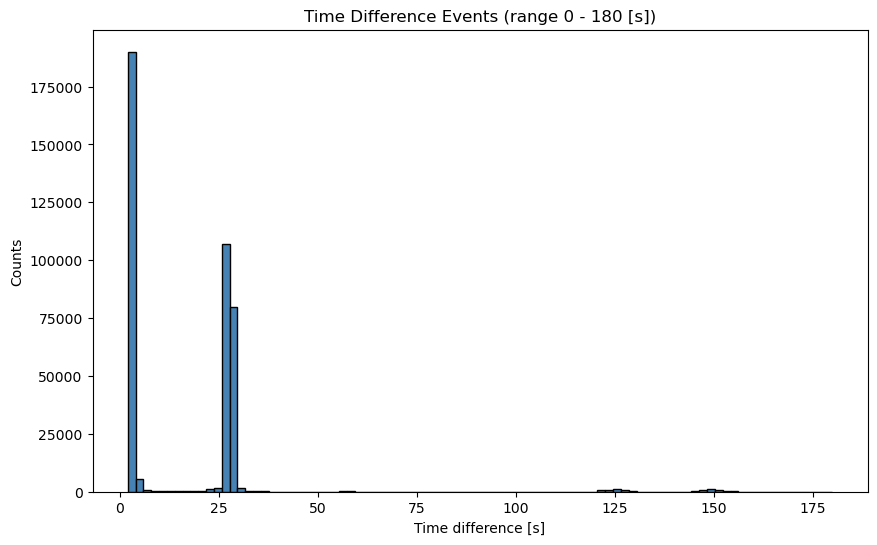

In [28]:
plot_diff_histogram(differences=diffs, min_diff=0, max_diff=180, delta=2)

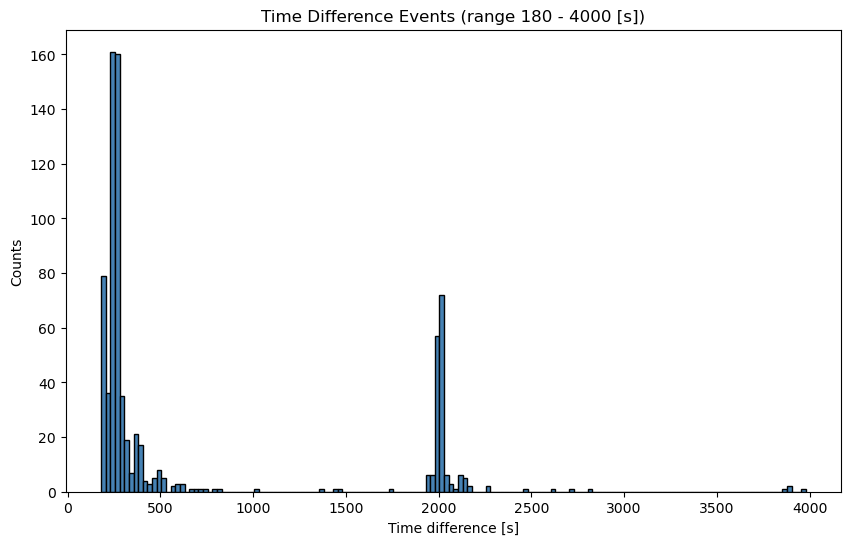

In [29]:
plot_diff_histogram(differences=diffs, min_diff=180, max_diff=4000, delta=25)

# Handling missing data & gaps

### Create final grid

Direi di tenere questa funzione "FillGaps" e continuare ad implementare partendo da questa

In [10]:
def CreateGrid(
    df: DataFrame,
    sensors: list = None,
    interval: int = 60,
    modality: str = 'auto',
) -> DataFrame:
    """
    Aggregates sensor data into fixed-size time windows and fills missing values using Spark.

    Args:
        df: Spark DataFrame with a 'when' column (UNIX timestamp in seconds).
        sensors: List of sensor column names. If None, inferred from all columns except 'when' and 'time'.
        interval: Window size in seconds.
        modality: Aggregation method: 'mean', 'min', 'max', 'mode', or 'auto'.
        fill_null: If True, fills missing values using forward and backward fill in Spark.

    Returns:
        Aggregated and optionally gap-filled DataFrame, with a `when` column at the center of the window
        and a `window_id` column that uniquely identifies each time window.
    """

    # 1. Infer sensor columns if not provided
    if sensors is None:
        sensors = [c for c in df.columns if c not in ("when", "time")]

    # 2. Add timestamp column
    df_ts = df.withColumn("timestamp", from_unixtime(col("when")).cast("timestamp"))

    # 3. Create time window
    df_windowed = df_ts.withColumn("time_window", window("timestamp", f"{interval} seconds"))

    # 4. Aggregate using selected modality
    if modality == "mode":
        # Special case: MODE needs groupBy and count per window + sensor
        aggs = []
        for s in sensors:
            mode_df = (
                df_windowed.groupBy("time_window", s)
                .agg(count("*").alias("cnt"))
                .withColumn("rank", row_number().over(
                    Window.partitionBy("time_window").orderBy(desc("cnt"))
                ))
                .filter(col("rank") == 1)
                .select("time_window", col(s).alias(s))
            )
            if not aggs:
                result_df = mode_df
            else:
                result_df = result_df.join(mode_df, on="time_window", how="outer")
    else:
        aggs = []
        for s in sensors:
            if modality == "mean":
                agg_func = spark_avg(col(s)).alias(s)
            elif modality == "min":
                agg_func = spark_min(col(s)).alias(s)
            elif modality == "max":
                agg_func = spark_max(col(s)).alias(s)
            elif modality == "auto":
                stats = df.selectExpr(f"min({s}) as min", f"max({s}) as max").first()
                is_binary = stats["min"] is not None and stats["max"] is not None and 0 <= stats["min"] and stats["max"] <= 1
                if s in ["A5", "A9"] or is_binary:
                    agg_func = spark_max(col(s)).alias(s)
                else:
                    agg_func = spark_avg(col(s)).alias(s)
            else:
                raise ValueError(f"Unsupported modality: {modality}")
            aggs.append(agg_func)

        result_df = (
            df_windowed
            .groupBy("time_window")
            .agg(*aggs)
        )

    # 5. Add window_start, window_end, and 'when' as center of window
    result_df = (
        result_df
        .withColumn("window_start", col("time_window.start"))
        .withColumn("window_end", col("time_window.end"))
        .withColumn("when", expr("unix_timestamp(window_start) + int((unix_timestamp(window_end) - unix_timestamp(window_start)) / 2)"))
        .drop("time_window")
        .orderBy("when")
    )

    # 6. Spostato in BuildBlocks

    
    # 7. Add window_id as progressive row number
    result_df = result_df.withColumn("window_id", monotonically_increasing_id())

    return result_df.select(["window_id", "when", "window_start", "window_end"] + sensors)

    # 6. Optionally fill nulls using Pandas (costly)
    # if fill_null:
    #     pandas_df = result_df.toPandas()
    #     pandas_df = pandas_df.ffill().bfill()
    #     return spark.createDataFrame(pandas_df)
    # else:
    #     return result_df

In [38]:
# df_final.unpersist()
# df_final.show(1)

In [11]:
%%time

frequency = 60 #seconds

# Fill sensor gaps
df_grid = CreateGrid(df_hw, interval=frequency, modality="auto")
df_grid = df_grid.persist()

# Trigger persist
df_grid.count()

df_hw.unpersist()

[Stage 1531:=============================================>      (175 + 6) / 200]

CPU times: user 261 ms, sys: 91.8 ms, total: 352 ms
Wall time: 53.5 s


DataFrame[when: int, A5: int, A9: int, ComError: int, P1: int, P10: int, P15: int, P16: int, P17: int, P18: int, P2: int, P5: int, P6: int, P7: int, P8: int, P9: int, S1: int, S10: int, S100: int, S101: int, S102: int, S106: int, S107: int, S108: int, S109: int, S11: int, S110: int, S112: int, S113: int, S114: int, S115: int, S117: int, S118: int, S122: int, S123: int, S124: int, S125: int, S126: int, S127: int, S128: int, S129: int, S130: int, S137: int, S138: int, S140: int, S143: int, S147: int, S15: int, S151: int, S154: int, S157: int, S158: int, S159: int, S16: int, S163: int, S164: int, S165: int, S166: int, S167: int, S169: int, S17: int, S170: int, S171: int, S172: int, S173: int, S174: int, S175: int, S176: int, S178: int, S179: int, S180: int, S181: int, S183: int, S19: int, S2: int, S201: int, S202: int, S203: int, S204: int, S205: int, S206: int, S25: int, S3: int, S33: int, S34: int, S35: int, S37: int, S39: int, S40: int, S41: int, S42: int, S43: int, S45: int, S46: int,

In [22]:
df_grid.select("window_id", "when", "window_start", "window_end", "S110", "S112", "S113", "S114", "S115", "S117", "S118", "S122", "A9").show(20, truncate = False)

+---------+----------+-------------------+-------------------+----+----+----+----+----+----+----+-----+----+
|window_id|when      |window_start       |window_end         |S110|S112|S113|S114|S115|S117|S118|S122 |A9  |
+---------+----------+-------------------+-------------------+----+----+----+----+----+----+----+-----+----+
|0        |1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|0   |1   |1   |0   |0   |0   |1   |410.0|NULL|
|1        |1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00|0   |1   |1   |0   |0   |0   |1   |406.5|NULL|
|2        |1601510550|2020-10-01 00:02:00|2020-10-01 00:03:00|0   |1   |1   |0   |0   |0   |1   |409.0|NULL|
|3        |1601510610|2020-10-01 00:03:00|2020-10-01 00:04:00|0   |1   |1   |0   |0   |0   |1   |406.5|NULL|
|4        |1601510670|2020-10-01 00:04:00|2020-10-01 00:05:00|0   |1   |1   |0   |0   |0   |1   |406.5|NULL|
|5        |1601510730|2020-10-01 00:05:00|2020-10-01 00:06:00|0   |1   |1   |0   |0   |0   |1   |407.5|NULL|
|6        |16015107

### Block Structure

In [12]:
from pyspark.sql import functions as F


def BuildBlocks(df, max_interval):
    #Block Partitioning
    w_global = Window.partitionBy(F.lit(1)).orderBy("when")
    df = (df
          .withColumn("Prev_TimeStamp", F.lag("when").over(w_global))
          .withColumn("Next_TimeStamp", F.lead("when").over(w_global))
          .withColumn("PrevDiff_s", F.col("when") - F.col("Prev_TimeStamp"))
          .withColumn("NextDiff_s", F.col("Next_TimeStamp") - F.col("when"))
         )

    #Check if the timediff between two consecutive data is more than max_interval
    df = df.withColumn(
        "CheckNewBlock",
        F.when(F.col("PrevDiff_s") > max_interval, 1).otherwise(0))
    df = df.withColumn("BlockID", F.sum("CheckNewBlock").over(w_global))

    #Copy these rows if there are any gaps (timediff > 60 but less than max_interval)
    skip_cols = {
        "when", "Prev_TimeStamp", "Next_TimeStamp",
        "PrevDiff_s", "NextDiff_s", "CheckNewBlock", "BlockID",
        "window_start", "window_end"}
    other_cols = [c for c in df.columns if c not in skip_cols]

    # Next values (lead) within EACH block to copy if there are gaps
    w_block = Window.partitionBy("BlockID").orderBy("when")
    for c in other_cols:
        df = df.withColumn(f"Next_{c}", F.lead(c).over(w_block))

    #Fill values only for intra-block gaps: 60 < gap < max_interval
    df = df.withColumn(
        "NumFill",
        F.when(
            (F.col("NextDiff_s") > 60) & (F.col("NextDiff_s") < max_interval),
            (F.floor(F.col("NextDiff_s")/60) - 1).cast("int")).otherwise(0))

    #Timestamps to insert between current and next row (every 60s)
    df = df.withColumn("FillTimestamps",
            F.when(F.col("NumFill") > 0,
                    F.expr("sequence(when + 60, Next_TimeStamp - 60, 60)")).otherwise(F.array()))

    #Artificial rows copy NEXT row's non-time columns
    fill_rows = (df
        .filter(F.col("NumFill") > 0)
        .select("BlockID",
            F.explode("FillTimestamps").alias("when"),
            *[F.col(f"Next_{c}").alias(c) for c in other_cols],
            F.lit(True).alias("is_artificial")))

    #Original rows
    original_rows = df.select("BlockID", "when", *other_cols, F.lit(False).alias("is_artificial"))

    #Union, order, recompute windows from 'when'
    final = (original_rows.unionByName(fill_rows)
             .orderBy("BlockID", "when"))

    # Recompute window_id and window bounds
    w_block_final = Window.partitionBy("BlockID").orderBy("when")
    final = (final
             .withColumn("window_id", F.row_number().over(w_block_final) - 1)
             .withColumn("window_start", F.from_unixtime(F.col("when") - 30))
             .withColumn("window_end",   F.from_unixtime(F.col("when") + 30)))

    #Recompute TimeDiff_s after filling
    final = (final
             .withColumn("PrevWhenInBlock", F.lag("when").over(w_block_final))
             .withColumn("TimeDiff_s",
                 F.when(F.col("PrevWhenInBlock").isNull(), F.lit(None).cast("int"))
                  .otherwise(F.col("when") - F.col("PrevWhenInBlock"))).drop("PrevWhenInBlock"))

    return final

In [13]:
%%time

df_final = BuildBlocks(df_grid, max_interval = 240)
df_final.select("window_id", "when", "window_start", "window_end", "TimeDiff_s", "BlockID").show(20)

df_final = df_final.persist()
df_final.count()
df_grid.unpersist()

+---------+----------+-------------------+-------------------+----------+-------+
|window_id|      when|       window_start|         window_end|TimeDiff_s|BlockID|
+---------+----------+-------------------+-------------------+----------+-------+
|        0|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|      NULL|      0|
|        1|1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00|        60|      0|
|        2|1601510550|2020-10-01 00:02:00|2020-10-01 00:03:00|        60|      0|
|        3|1601510610|2020-10-01 00:03:00|2020-10-01 00:04:00|        60|      0|
|        4|1601510670|2020-10-01 00:04:00|2020-10-01 00:05:00|        60|      0|
|        5|1601510730|2020-10-01 00:05:00|2020-10-01 00:06:00|        60|      0|
|        6|1601510790|2020-10-01 00:06:00|2020-10-01 00:07:00|        60|      0|
|        7|1601510850|2020-10-01 00:07:00|2020-10-01 00:08:00|        60|      0|
|        8|1601510910|2020-10-01 00:08:00|2020-10-01 00:09:00|        60|      0|
|        9|16015

[Stage 1674:=============================================>      (174 + 3) / 200]

CPU times: user 117 ms, sys: 63 ms, total: 180 ms
Wall time: 48.5 s


DataFrame[window_id: bigint, when: bigint, window_start: timestamp, window_end: timestamp, A5: int, A9: int, ComError: int, P1: double, P10: double, P15: int, P16: double, P17: double, P18: double, P2: int, P5: double, P6: double, P7: double, P8: double, P9: double, S1: int, S10: double, S100: double, S101: double, S102: double, S106: int, S107: double, S108: int, S109: double, S11: int, S110: int, S112: int, S113: int, S114: int, S115: int, S117: int, S118: int, S122: double, S123: double, S124: double, S125: double, S126: double, S127: int, S128: double, S129: double, S130: double, S137: double, S138: double, S140: double, S143: double, S147: double, S15: int, S151: double, S154: double, S157: double, S158: double, S159: double, S16: int, S163: int, S164: double, S165: int, S166: double, S167: int, S169: int, S17: int, S170: int, S171: int, S172: int, S173: int, S174: int, S175: int, S176: int, S178: double, S179: double, S180: double, S181: double, S183: int, S19: int, S2: double, S

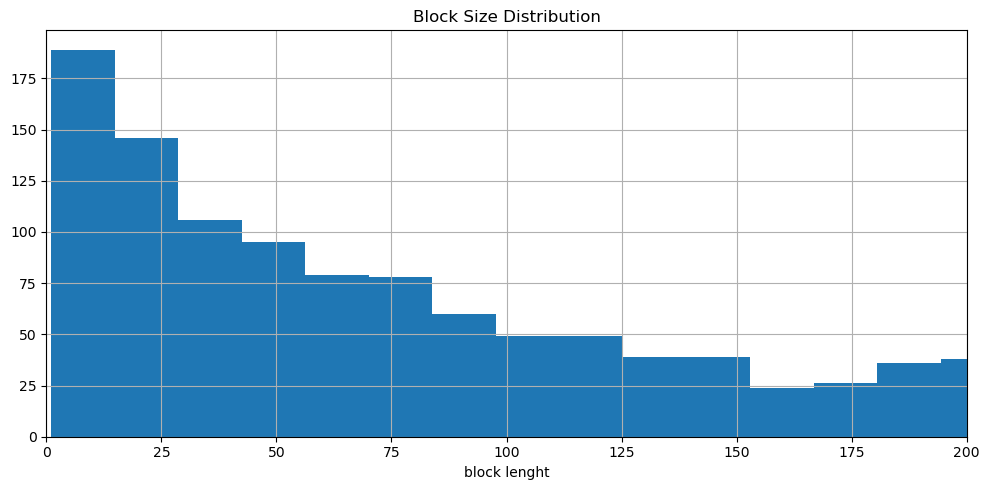

In [21]:
Dist = df_final.groupBy("BlockID").count().orderBy("BlockID")

data = Dist.toPandas()
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(data['count'], bins = 150)
plt.xlim(0, 200)
plt.xlabel("block lenght")
#plt.ylabel("Number of Rows in Block")
plt.title("Block Size Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test = df_final.toPandas()
t = test[test['BlockID'] == 118]['S117']
x = np.arange(len(t))
plt.bar(x, t, width=1)  # larghezza massima per togliere lo spazio

plt.show()

# Anomaly detection

In [41]:
# df_final.select("window_id", "when", "window_start", "window_end", "TimeDiff_s", "BlockID", "S117").orderBy('BlockID').show(20)

### Prove Anomaly

In [15]:
def createDummyAnomaly(nBlocks, feature_name, values):
    
    schema = StructType([
        StructField("BlockID", IntegerType(), True),
        StructField("window_id", IntegerType(), True),
        StructField("when", IntegerType(), True),
        StructField(feature_name, IntegerType(), True)
    ])

    data = []

    for k in range(nBlocks):
        for n in range(len(values)):
            data.append((k, n, k*len(values)+n*60, values[n]))

    df = spark.createDataFrame(data, schema)
    return df.orderBy('BlockID','when')
        

In [16]:
dummy_df = createDummyAnomaly(2, 'S117', [0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,0,0,0,0,1,1,1,1])
dummy_df.show(30)

+-------+---------+----+----+
|BlockID|window_id|when|S117|
+-------+---------+----+----+
|      0|        0|   0|   0|
|      0|        1|  60|   0|
|      0|        2| 120|   1|
|      0|        3| 180|   1|
|      0|        4| 240|   1|
|      0|        5| 300|   0|
|      0|        6| 360|   0|
|      0|        7| 420|   0|
|      0|        8| 480|   0|
|      0|        9| 540|   1|
|      0|       10| 600|   1|
|      0|       11| 660|   0|
|      0|       12| 720|   1|
|      0|       13| 780|   0|
|      0|       14| 840|   1|
|      0|       15| 900|   0|
|      0|       16| 960|   0|
|      0|       17|1020|   0|
|      0|       18|1080|   0|
|      0|       19|1140|   1|
|      0|       20|1200|   1|
|      0|       21|1260|   1|
|      0|       22|1320|   1|
|      1|        0|  23|   0|
|      1|        1|  83|   0|
|      1|        2| 143|   1|
|      1|        3| 203|   1|
|      1|        4| 263|   1|
|      1|        5| 323|   0|
|      1|        6| 383|   0|
+-------+-

In [18]:
# Prova per verificare se funziona

dummy_anomalies = detect_anomalies(
    df = dummy_df,
    time_separator = 3*60, # seconds
    threshold = 2,
    sensors = ['S117'],
    extended = True,
    debug = True
)

dummy_anomalies \
    .show(30, truncate = False)

+-------+---------+----+----+--------------+---------------+--------------+----------+---------+-----------+-----------+
|BlockID|window_id|when|S117|didSwitch_S117|startGroup_S117|anomalyID_S117|count_S117|flag_S117|prevID_S117|nextID_S117|
+-------+---------+----+----+--------------+---------------+--------------+----------+---------+-----------+-----------+
|0      |0        |0   |0   |0             |NULL           |NULL          |16        |false    |NULL       |NULL       |
|0      |1        |60  |0   |0             |NULL           |NULL          |16        |false    |NULL       |NULL       |
|0      |2        |120 |1   |1             |1              |1             |1         |false    |NULL       |NULL       |
|0      |3        |180 |1   |0             |NULL           |NULL          |16        |false    |NULL       |NULL       |
|0      |4        |240 |1   |0             |NULL           |NULL          |16        |false    |NULL       |NULL       |
|0      |5        |300 |0   |1  

### Official anomaly on dataset

In [14]:
def detect_anomalies(df, time_separator, threshold, sensors, extended = False, debug = False):
    '''
    Crea colonne con flag per anomalie.
    '''
    # Lag to get previous value within each partition (i.e. within each block)
    window         = Window.partitionBy("BlockID").orderBy("window_id")
    lagged_columns = [lag(col(s)).over(window) for s in sensors] 
    lag_names      = [f"lagged_{s}" for s in sensors]
    
    df_lagged = df.withColumns(dict(zip(lag_names, lagged_columns)))

    # Determina switch del sensore (didSwitch = 1 se il sensore passa da 0 a 1 o viceversa, didSwitch = 0 altrimenti)
    switch_w     = Window.partitionBy('BlockID').orderBy('window_id')
    didSwitch    = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] 
    switch_names = [f"didSwitch_{s}" for s in sensors]    

    df_didSwitch = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Detect anomaly group: when two clusters are more distant than time_separator they are grouped as different anomalies
    # Tutte le anomalie di uno stesso gruppo hanno stesso id, cioè un numero crescente che si resetta ad ogni nuovo blocco
    df_anomalies = df_didSwitch
    for sensor in sensors:   
        # Il periodo anomalo inizia quando il sensore è 1 e finisce quando esso è 0
        df_start = (
            df_didSwitch \
            .withColumn(f'theres0Before_{sensor}', count_if(col(sensor) == 0).over(window.rowsBetween(1, int(time_separator/60))) > 0) \
            .withColumn(f'theres0After_{sensor}', count_if(col(sensor) == 0).over(window.rowsBetween(-int(time_separator/60), -1)) > 0) \
            .filter( 
                (col(f'didSwitch_{sensor}') == 1) & 
                (when(col(sensor) == 1, col(f'theres0Before_{sensor}')).otherwise(True)) &
                (when(col(sensor) == 0, col(f'theres0After_{sensor}')).otherwise(True))
            ) \
            .withColumn(f'startGroup_{sensor}', when((col('when')-lag(col('when'), 1, -1e9).over(window))>time_separator, 1).otherwise(0)) \
            .withColumn(f'anomalyID_{sensor}', spark_sum(col(f'startGroup_{sensor}')).over(window)) \
        )
        
        df_anomalies = df_anomalies.join(
            other = df_start.select('BlockID', 'window_id', f'startGroup_{sensor}', f'anomalyID_{sensor}'),
            on = ['BlockID', 'window_id'],
            how = 'left'
        )

    count_names = [f'count_{s}' for s in sensors]
    count_cols  = [count('*').over(Window.partitionBy('BlockID', f'anomalyID_{s}')) for s in sensors]

    flag_names  = [f'flag_{s}' for s in sensors]
    flag_cols   = [when((col(f'count_{s}') >= threshold) & (col(f'anomalyID_{s}') > 0), True).otherwise(False) for s in sensors]
    
    df_flag = df_anomalies \
        .withColumns(dict(zip(count_names, count_cols))) \
        .withColumns(dict(zip(flag_names, flag_cols))) \
        .orderBy('BlockID', 'window_id')

    #
    # Se c'è questa parte, abbiamo la detection secondo Marco
    # Quando ci sono delle righe tra anomalie con stesso ID, queste righe sono a loro volta considerare anomalie
    #

    if extended:
        
        next_w  = Window.partitionBy('BlockID').orderBy('window_id').rowsBetween(0, int(time_separator/60))
        prev_w  = Window.partitionBy('BlockID').orderBy('window_id').rowsBetween(-int(time_separator/60), 0)

        prev_names = [f'prevID_{s}' for s in sensors]
        prev_id = [when((bool_or(f'flag_{s}').over(prev_w)), spark_max(f'anomalyID_{s}').over(prev_w)).otherwise(None) for s in sensors]
        next_names = [f'nextID_{s}' for s in sensors]
        next_id = [when((bool_or(f'flag_{s}').over(next_w)), spark_min(f'anomalyID_{s}').over(next_w)).otherwise(None) for s in sensors]

        df_newID = (
            df_flag \
                .withColumns(dict(zip(prev_names, prev_id))) \
                .withColumns(dict(zip(next_names, next_id)))
        )

        new_flags = [when((col(f'nextID_{s}') == col(f'prevID_{s}')) & (col(f'nextID_{s}') > 0), True).otherwise(col(f'flag_{s}')) for s in sensors]
        
        df_flag = df_newID.withColumns(dict(zip(flag_names, new_flags)))

    if debug:
        if extended:
            return df_flag \
                .select("BlockID", "window_id", "when", 'S117' ,'didSwitch_S117','startGroup_S117','anomalyID_S117','count_S117', 'flag_S117', 'prevID_S117', 'nextID_S117') # per testare dummy_df
        else:
            return df_flag \
                .select("BlockID", "window_id", "when", 'S117' ,'didSwitch_S117','startGroup_S117','anomalyID_S117','count_S117', 'flag_S117') # per testare dummy_df
    else:
        return df_flag \
            .select("BlockID", "window_id", "when", *sensors, *flag_names) 
    

In [15]:
%%time

# df effettivo

df_anomalies = detect_anomalies(
    df = df_final,
    time_separator = 60*10, # seconds
    threshold = 2,
    sensors = ['S117', 'S118', 'S170', 'S171'],
    extended = True,
    debug = True 
)

df_anomalies \
    .filter('flag_S117') \
    .select('BlockID').distinct() \
    .show(20, truncate=False)

[Stage 1738:==============================================>     (178 + 2) / 200]]0]

+-------+
|BlockID|
+-------+
|49     |
|60     |
|63     |
|73     |
|91     |
|93     |
|102    |
|111    |
|112    |
|116    |
|120    |
|122    |
|130    |
|138    |
|149    |
|158    |
|160    |
|165    |
|171    |
|172    |
+-------+
only showing top 20 rows



In [16]:
def inspect_anomalies(df_anomalies, sensor, blockID, rowsToShow = 0):
    '''
    Bar plot delle anomalie nel tempo.
    '''

    if rowsToShow > 0:
        df_anomalies \
            .select('BlockID','window_id','S117', 'flag_S117') \
            .filter(col('BlockID') == blockID) \
            .show(rowsToShow, truncate=False)

    #--------------------------------------------
    
    def extract_column(df, column, default):
        return df \
            .filter(col('BlockID') == blockID) \
            .select(when(col(column).isNull(), default).otherwise(col(column))) \
            .rdd.flatMap(lambda x: x).collect()

    values    = extract_column(df_anomalies, sensor, 0)
    anomalies = extract_column(df_anomalies, f'flag_{sensor}', False)
    # timeDiff  = extract_column(df_anomalies, 'TimeDiff_s')
    t = range(len(anomalies))

    plt.bar(t, values, width = 1, alpha = 0.5, edgecolor='black', lw=1)
    plt.bar(t, anomalies, width= 1, alpha = 0.5, label="anomaly period")
    plt.xlabel("# misura")
    plt.ylabel(sensor)
    # plt.xticks([])
    #plt.title("misure in successione")
    plt.legend()
    plt.show()

                                                                                0]

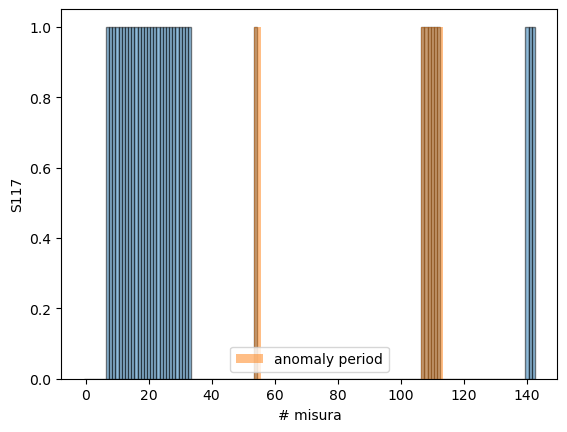

In [28]:
inspect_anomalies(df_anomalies, 'S117', 28)

                                                                                0]

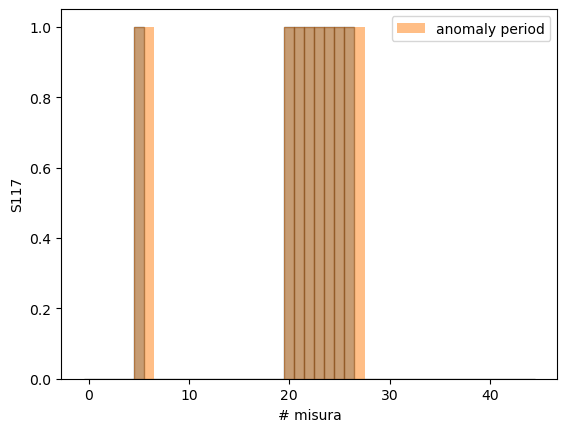

In [29]:
inspect_anomalies(df_anomalies, 'S117', 21)

                                                                                0]

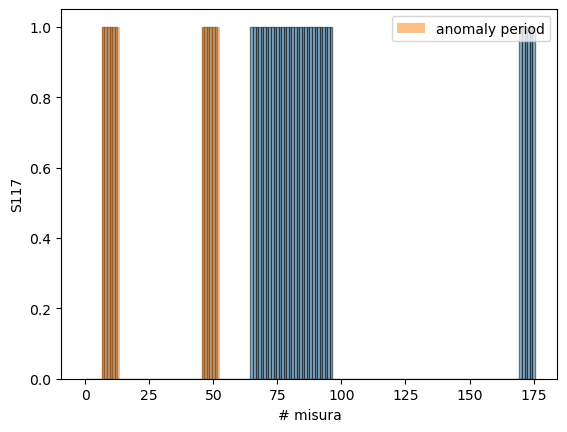

In [30]:
inspect_anomalies(df_anomalies, 'S117', 118)

                                                                                0]

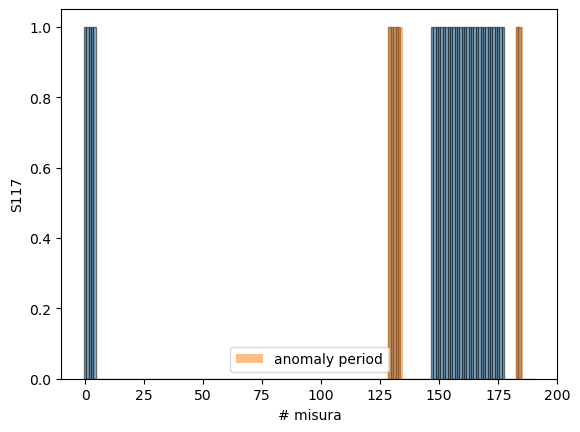

In [31]:
inspect_anomalies(df_anomalies, 'S117', 120)

                                                                                00]

+-------+---------+----+---------+
|BlockID|window_id|S117|flag_S117|
+-------+---------+----+---------+
|124    |0        |0   |false    |
|124    |1        |0   |false    |
|124    |2        |0   |false    |
|124    |3        |0   |false    |
|124    |4        |0   |false    |
|124    |5        |0   |false    |
|124    |6        |0   |false    |
|124    |7        |0   |false    |
|124    |8        |0   |false    |
|124    |9        |0   |false    |
|124    |10       |0   |false    |
|124    |11       |0   |false    |
|124    |12       |0   |false    |
|124    |13       |0   |false    |
|124    |14       |0   |false    |
|124    |15       |0   |false    |
|124    |16       |1   |true     |
|124    |17       |1   |true     |
|124    |18       |1   |true     |
|124    |19       |1   |true     |
|124    |20       |1   |true     |
|124    |21       |0   |true     |
|124    |22       |0   |false    |
|124    |23       |0   |false    |
|124    |24       |0   |false    |
|124    |25       |0

                                                                                0]

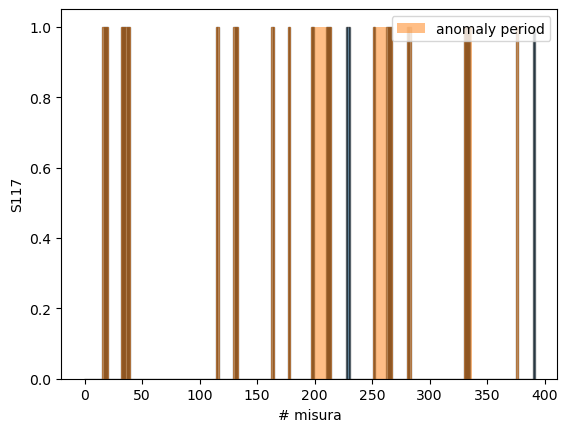

In [32]:
inspect_anomalies(df_anomalies, 'S117', 124, 300)

In [33]:
df_anomalies = df_anomalies.withColumn(
    "flag_anomaly",
    when(
        (col('flag_S117') == True) | (col('flag_S117') == True) | (col('flag_S117') == True)  | (col('flag_S117') == True) ,
        1
    ).otherwise(0).cast('int'))


df_anomalies = df_anomalies.persist()
df_anomalies.where(col('flag_anomaly')==True).show(50)

                                                                                0]]

+-------+---------+----------+----+--------------+---------------+--------------+----------+---------+-----------+-----------+------------+
|BlockID|window_id|      when|S117|didSwitch_S117|startGroup_S117|anomalyID_S117|count_S117|flag_S117|prevID_S117|nextID_S117|flag_anomaly|
+-------+---------+----------+----+--------------+---------------+--------------+----------+---------+-----------+-----------+------------+
|     26|        4|1601742630|   1|             1|              1|             1|         2|     true|          1|          1|           1|
|     26|        5|1601742690|   0|             1|              0|             1|         2|     true|          1|          1|           1|
|     29|       40|1601756070|   1|             1|              1|             1|         2|     true|          1|          1|           1|
|     29|       41|1601756130|   1|             0|           NULL|          NULL|       415|     true|          1|          1|           1|
|     29|       42|1

In [23]:
df_anomalies.show(1)

+-------+---------+----------+-------------------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|BlockID|window_id|      when|       window_start|TimeDiff_s|S117|S118|S170|S171|flag_S117|flag_S118|flag_S170|flag_S171|flag_anomaly|
+-------+---------+----------+-------------------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|     26|        0|1601742390|2020-10-03 16:26:00|      NULL|   0|   1|   1|   1|    false|    false|    false|    false|           0|
+-------+---------+----------+-------------------+----------+----+----+----+----+---------+---------+---------+---------+------------+
only showing top 1 row



In [18]:
# Join on `when` and bring `flag_anomaly` into df_final

df_anom = df_anomalies.select('when', 'flag_anomaly')
df_anom = spark.createDataFrame(df_anom.rdd, df_anom.schema)  # Break lineage

df_final_anom = df_final.join(df_anom, df_final.when == df_anom.when, "left").persist()

df_final_anom.show(1)

[Stage 1939:==================================================> (195 + 2) / 200]

+-------+----------+---------+----+----+--------+---+-----+---+-----+-----+-----+---+-----+-----+-----+-----+-----+---+---+----+----+----+----+-----+----+-----+---+----+----+----+----+----+----+----+----+----+------+----+----+----+-----+-----+----+-----+----+----+-----+-----+---+----+----+-----+-----+-----+---+----+-----+----+-----+----+----+---+----+----+----+----+----+----+----+----+----+-------+----+----+---+---+------+------+------+------+------+------+---+-----+---+---+---+------+-----+-----+-----+---+---+---+-----+-----+---+---+---+---+---+---+---+---+-----+---+---+---+---+------+----+----+---+---+----+-----+-----+-----+---+-----+-----+-----+---+----+----+----+---+---+---+-------+---+---+---+---+---+-------------+-------------------+-------------------+----------+----------+------------+
|BlockID|      when|window_id|  A5|  A9|ComError| P1|  P10|P15|  P16|  P17|  P18| P2|   P5|   P6|   P7|   P8|   P9| S1|S10|S100|S101|S102|S106| S107|S108| S109|S11|S110|S112|S113|S114|S115|S117|S

# Save df_final [DA ELIMINAR PRIMA DELLA CONSEGNA]

In [19]:
print(hardware)

SW-088


In [20]:
%%time

# SOVRASCRIVE IL FILE SE ESISTE GIA' UNO CON LO STESSO NOME

try:
    # Converti e salva
    pandas_df = df_final_anom.toPandas()
    file_path = f"/mnt/shared/df_final_{hardware}.csv"
    pandas_df.to_csv(file_path, index=False, header=True)
    
    # Imposta permessi
    os.chmod(file_path, 0o775)

    '''
    Spiegazione dei permessi:
    -rwxrwxr-x corrisponde a 775 in ottale:
    rwx (owner): 4+2+1 = 7 (read+write+execute)
    rwx (group): 4+2+1 = 7 (read+write+execute)
    r-x (others): 4+0+1 = 5 (read+execute, no write)
    '''
    
    print(f"File creato e permessi impostati: {file_path}")
    
except Exception as e:
    print(f"Errore: {e}")

File creato e permessi impostati: /mnt/shared/df_final_SW-088.csv
CPU times: user 10.2 s, sys: 1.57 s, total: 11.8 s
Wall time: 15 s


# Correlations

In [32]:
from pyspark.sql.functions import approx_count_distinct
from pyspark.sql.functions import countDistinct


#Given the dataframe, returns a dataframe with (approx.) the number of unique values assumed by each sensor in grouped by BlockID
#To be called once after Anomaly detection
def ChangingMetrics(df, sensors):
    
    ColToCount = [c for c in df.columns if c in sensors]
    
    agg_exprs = [approx_count_distinct(c, 0.15).alias(c) for c in ColToCount]
    
    # Aggregate distinct counts on half the dataset (some assumptions needed)
    sample_df = df
    counts_df = sample_df.agg(*agg_exprs)

    #Collect only the name of the sensors that changed at least 20 times on half the dataset
    row = counts_df.collect()[0].asDict()

    # One-liner to get qualifying sensor names
    QualitySensors = [name for name, count in row.items() if count == 2 or count >= 10]

    return QualitySensors

In [32]:
%%time

engines = ['S117', 'S118', 'S170', 'S171']
sensors_interest = [s for s in sensors if s not in engines]

QualitySensors = ChangingMetrics(df_final_anom, sensors_interest)


25/08/17 08:47:20 WARN DAGScheduler: Broadcasting large task binary with size 1023.7 KiB
[Stage 2380:==================================================> (196 + 2) / 200]

CPU times: user 67.8 ms, sys: 14.7 ms, total: 82.5 ms
Wall time: 12.1 s


25/08/17 08:47:31 WARN DAGScheduler: Broadcasting large task binary with size 1314.8 KiB
                                                                                

In [33]:
print(len(QualitySensors))
QualitySensors

84


['A9',
 'ComError',
 'P18',
 'P2',
 'S1',
 'S10',
 'S100',
 'S101',
 'S102',
 'S107',
 'S109',
 'S112',
 'S113',
 'S114',
 'S115',
 'S122',
 'S123',
 'S124',
 'S125',
 'S126',
 'S127',
 'S128',
 'S129',
 'S130',
 'S137',
 'S138',
 'S140',
 'S143',
 'S147',
 'S151',
 'S154',
 'S157',
 'S158',
 'S159',
 'S164',
 'S166',
 'S169',
 'S172',
 'S173',
 'S174',
 'S178',
 'S179',
 'S180',
 'S181',
 'S183',
 'S201',
 'S202',
 'S203',
 'S204',
 'S205',
 'S206',
 'S25',
 'S3',
 'S33',
 'S35',
 'S37',
 'S39',
 'S40',
 'S41',
 'S46',
 'S47',
 'S5',
 'S53',
 'S55',
 'S6',
 'S64',
 'S7',
 'S70',
 'S71',
 'S72',
 'S73',
 'S8',
 'S80',
 'S81',
 'S83',
 'S86',
 'S9',
 'S90',
 'S94',
 'S97',
 'SA2',
 'SA3',
 'SA5',
 'SA9']

In [33]:
def correlations(df, sensors_list, target_col, batch_size=25):
    """
    Compute correlations between sensors and target column in batches.
    Returns sorted DataFrame by absolute correlation (descending).
    """   
    all_correlations = []
    
    # Process sensors in batches to avoid broadcasting large tasks
    for i in range(0, len(sensors_list), batch_size):
        batch_sensors = sensors_list[i:i + batch_size]
        
        # Create correlation expressions for current batch
        corr_expressions = [corr(target_col, sensor).alias(f"corr_{sensor}") for sensor in batch_sensors]
        
        # Execute correlations for this batch
        batch_results = df.agg(*corr_expressions).collect()[0]
        
        # Extract correlation values (handle nulls as 0.0)
        batch_correlations = [batch_results[f"corr_{sensor}"] or 0.0 
                            for sensor in batch_sensors]
        all_correlations.extend(batch_correlations)
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        "Sensors": sensors_list, 
        "Correlations": all_correlations
    })
    
    # Sort by absolute correlation (highest first)
    sorted_results = results_df.reindex(
        results_df["Correlations"].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)
    
    return sorted_results

In [34]:
def correlations_joblib(df, sensors_list, target_col, n_jobs=-1):

    
    # Create sensor batches
    # batch_size = 25
    processes = core if n_jobs == -1 else n_jobs
    processes = int(processes)
    
    if processes <= 0:
        raise ValueError("Number of processes must be greater than zero")
    
    batch_size = max(1, len(sensors_list) // processes)
    sensor_batches = [ sensors_list[i:i + batch_size]
                    for i in range(0, len(sensors_list), batch_size) ]
    
    def process_batch(batch_sensors):
        """Process a single batch of sensors"""
        corr_expressions = [corr(target_col, sensor).alias(f"corr_{sensor}") 
                           for sensor in batch_sensors]
        batch_results = df.agg(*corr_expressions).collect()[0]
        return [(sensor, batch_results[f"corr_{sensor}"] or 0.0) 
                for sensor in batch_sensors]
    
    # Parallel execution with joblib
    batch_results = Parallel(n_jobs=n_jobs, backend='threading')(
        delayed(process_batch)(batch) for batch in sensor_batches
    )
    
    # Flatten results
    all_results = []
    for batch_result in batch_results:
        all_results.extend(batch_result)
    
    # Create and sort DataFrame
    results_df = pd.DataFrame(all_results, columns=["Sensors", "Correlations"])
    return results_df.reindex(
        results_df["Correlations"].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)

In [35]:
def plot_scatter_corr(df_spark, target_col, feature_cols, corr_df):
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:
        corr_val = corr_df[corr_df["Sensors"] == feature]["Correlations"].values
        corr_val = corr_val[0] if len(corr_val) > 0 else None
        corr_str = f"{corr_val:.3f}" if corr_val is not None else "N/A"
        
        plt.figure(figsize=(6,4))
        plt.scatter(pd_df[feature], pd_df[target_col], color="steelblue", alpha=0.005)
        plt.title(f"{feature} (Correlation: {corr_str})")
        #plt.xlabel(feature)
        plt.ylabel(target_col)
        plt.show()

def plot_histograms_by_target(df_spark, target_col, feature_cols, corr_df):
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:

        corr_val = corr_df[corr_df["Sensors"] == feature]["Correlations"].values
        corr_val = corr_val[0] if len(corr_val) > 0 else None
        corr_str = f"{corr_val:.3f}" if corr_val is not None else "N/A"
        
        plt.figure(figsize=(6,4))
        for target_val, color in zip([0,1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            plt.hist(subset[feature], bins=30, alpha=0.5, color=color, label=f"{target_col}={target_val}", density=True)
        
        plt.title(f"{feature} (Correlation: {corr_str})")
        #plt.xlabel(feature)
        plt.ylabel("Density")
        plt.legend()
        plt.show()

In [26]:
%%time

anomaly_corr = correlations(df_final_anom.select(*QualitySensors,"flag_anomaly"), QualitySensors, "flag_anomaly")
anomaly_corr.head(100)

25/08/15 09:57:02 WARN DAGScheduler: Broadcasting large task binary with size 1025.7 KiB
25/08/15 09:57:10 WARN DAGScheduler: Broadcasting large task binary with size 1025.2 KiB
25/08/15 09:57:18 WARN DAGScheduler: Broadcasting large task binary with size 1025.6 KiB
[Stage 2374:============================================>       (173 + 4) / 200]

CPU times: user 83.8 ms, sys: 58.7 ms, total: 142 ms
Wall time: 28.3 s


,Sensors,Correlations
0,S9,0.061522
1,S10,0.026279
2,P16,-0.025961
3,S94,0.024080
4,S5,0.021767
...,...,...
78,SA1,-0.000044
79,SA6,-0.000044
80,SA10,-0.000044
81,S205,-0.000018


In [61]:
%%time

# with joblib

engines = ['S117', 'S118', 'S170', 'S171']

sensors_interest = [s for s in sensors if s not in engines]

anomaly_corr_joblib = correlations_joblib(df_final_anom.select(*QualitySensors,"flag_anomaly"), QualitySensors, "flag_anomaly")
anomaly_corr_joblib.head(len(sensors_interest))


Exception: java.lang.OutOfMemoryError thrown from the UncaughtExceptionHandler in thread "refresh progress"
25/08/15 09:42:41 WARN SingleThreadEventExecutor: Unexpected exception from an event executor: 
java.lang.OutOfMemoryError: Java heap space
25/08/15 09:42:41 WARN AbstractChannelHandlerContext: An exception 'java.lang.OutOfMemoryError: Java heap space' [enable DEBUG level for full stacktrace] was thrown by a user handler's exceptionCaught() method while handling the following exception:
java.lang.OutOfMemoryError: Java heap space
25/08/15 09:42:41 WARN SingleThreadEventExecutor: Unexpected exception from an event executor: 
java.lang.OutOfMemoryError: Java heap space
25/08/15 09:42:41 ERROR Utils: Uncaught exception in thread driver-heartbeater
java.lang.OutOfMemoryError: Java heap space


Py4JJavaError: An error occurred while calling o7923.collectToPython.
: java.lang.OutOfMemoryError: Java heap space


25/08/15 09:43:06 ERROR rejectedExecution: Failed to submit a listener notification task. Event loop shut down?
java.util.concurrent.RejectedExecutionException: event executor terminated
	at io.netty.util.concurrent.SingleThreadEventExecutor.reject(SingleThreadEventExecutor.java:934)
	at io.netty.util.concurrent.SingleThreadEventExecutor.offerTask(SingleThreadEventExecutor.java:351)
	at io.netty.util.concurrent.SingleThreadEventExecutor.addTask(SingleThreadEventExecutor.java:344)
	at io.netty.util.concurrent.SingleThreadEventExecutor.execute(SingleThreadEventExecutor.java:836)
	at io.netty.util.concurrent.SingleThreadEventExecutor.execute0(SingleThreadEventExecutor.java:827)
	at io.netty.util.concurrent.SingleThreadEventExecutor.execute(SingleThreadEventExecutor.java:817)
	at io.netty.util.concurrent.DefaultPromise.safeExecute(DefaultPromise.java:862)
	at io.netty.util.concurrent.DefaultPromise.notifyListeners(DefaultPromise.java:500)
	at io.netty.util.concurrent.DefaultPromise.addList

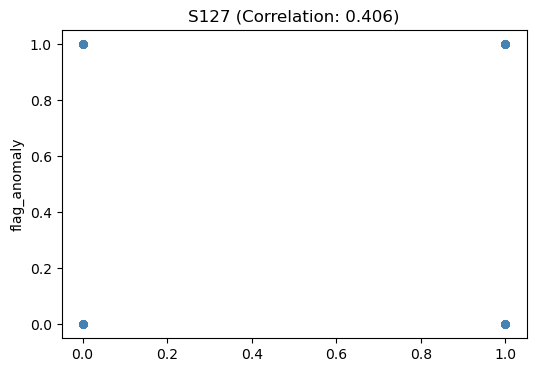

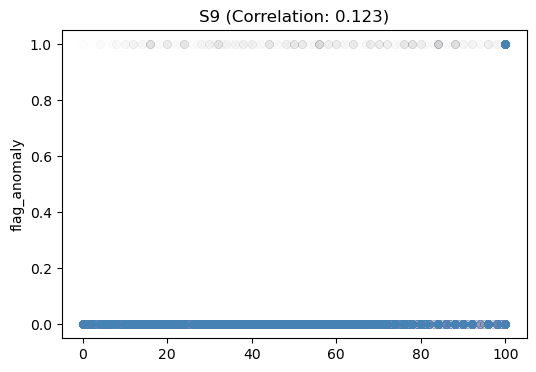

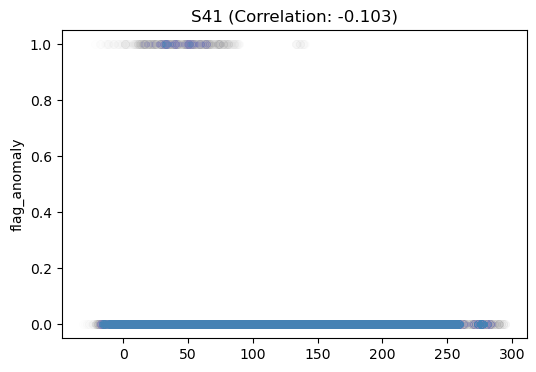

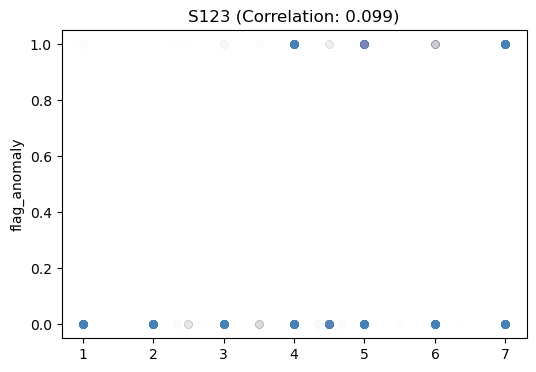

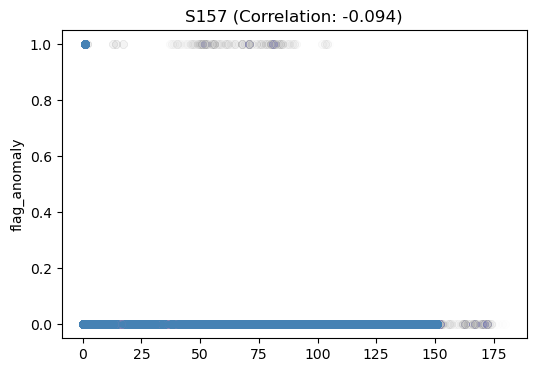

In [143]:
top_corr = anomaly_corr_joblib.head(5)["Sensors"].tolist()
plot_scatter_corr( df_final, "flag_anomaly", top_corr, anomaly_corr )

                                                                                200]

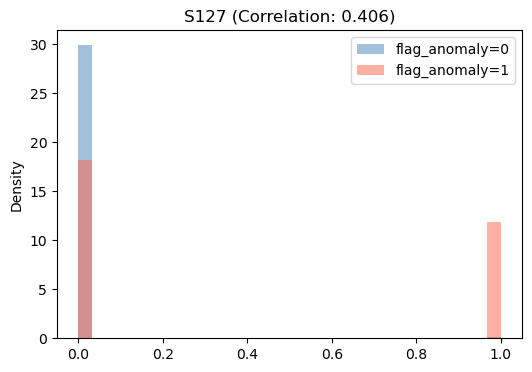

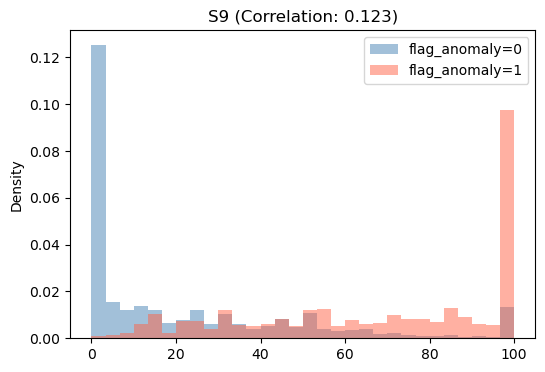

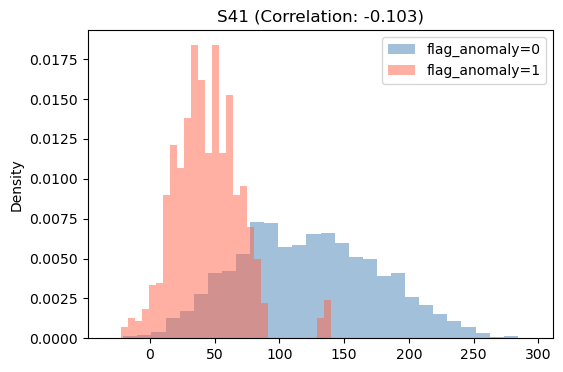

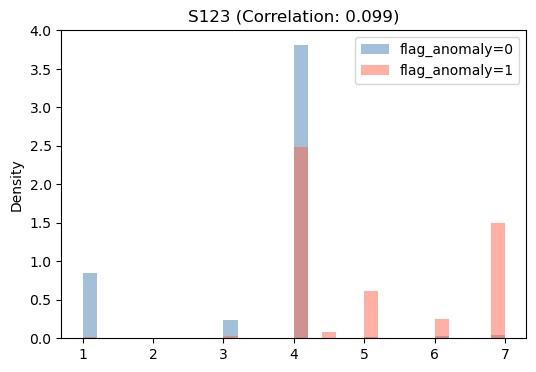

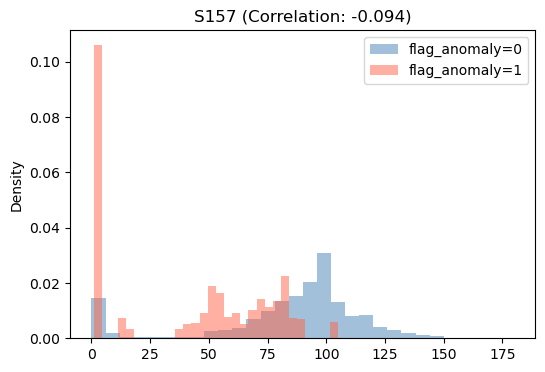

In [145]:
plot_histograms_by_target( df_final, "flag_anomaly", top_corr, anomaly_corr )

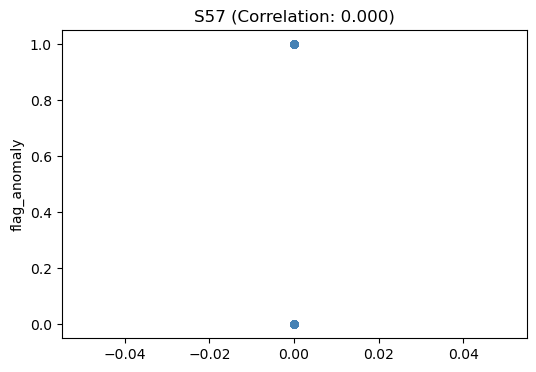

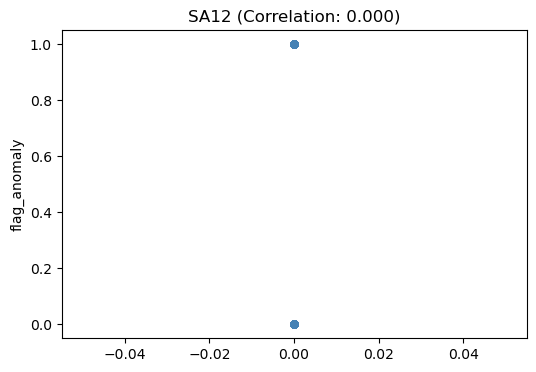

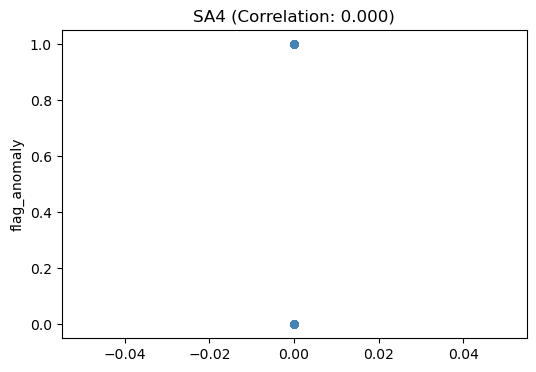

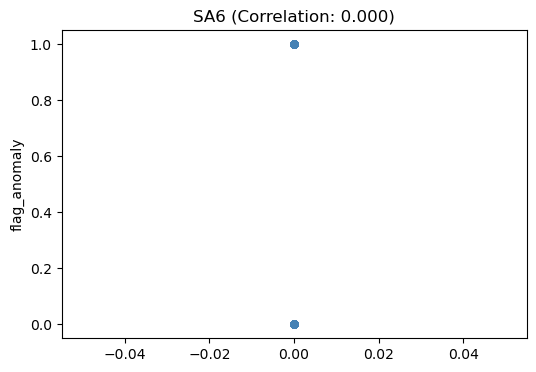

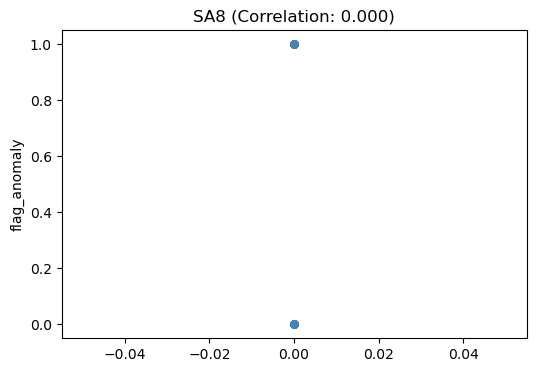

In [146]:
flop_corr = anomaly_corr_joblib.tail(5)["Sensors"].tolist()
plot_scatter_corr( df_final, "flag_anomaly", flop_corr, anomaly_corr )

In [163]:
def overlap_area(df, sensor_col, target_col, num_bins=50):
    """
    Computes % overlap between the distributions of sensor_col 
    for target_col = 0 and target_col = 1 using Spark histograms.
    """
    # Step 1: get min/max once
    min_max = df.agg(
        spark_min(sensor_col).alias("min_val"),
        spark_max(sensor_col).alias("max_val")
    ).first()
    min_val, max_val = float(min_max["min_val"]), float(min_max["max_val"])
    
    # Step 2: bin edges
    bin_edges = [min_val + i*(max_val-min_val)/num_bins for i in range(num_bins+1)]
    
    # Step 3: histograms for target=0 and target=1
    hist0 = df.filter(col(target_col) == 0).select(sensor_col).rdd.flatMap(lambda x: x).histogram(bin_edges)
    hist1 = df.filter(col(target_col) == 1).select(sensor_col).rdd.flatMap(lambda x: x).histogram(bin_edges)
    
    counts0, counts1 = hist0[1], hist1[1]  # second element is counts array
    
    # Step 4: normalizzazione in densità
    total0, total1 = sum(counts0), sum(counts1)
    density0 = [c/total0 for c in counts0]
    density1 = [c/total1 for c in counts1]
    
    # Step 5: area di intersezione
    overlap = sum(min(d0, d1) for d0, d1 in zip(density0, density1))
    
    return overlap * 100  # percentuale

In [174]:
%%time

top10_corr = anomaly_corr_joblib.head(10)["Sensors"].tolist()

for s in top10_corr:
    overlap_percent = overlap_area(df_final, s, "flag_anomaly", num_bins=60)
    corr_s = anomaly_corr_joblib.loc[anomaly_corr_joblib["Sensors"] == s, "Correlations"].values[0]
    print(f"Overlap with {s} %: {overlap_percent:.2f} (corr was {corr_s:.2f})")

                                                                                ] 200]

Overlap with S127 %: 60.86 (corr was 0.41)


                                                                                ]/ 200]

Overlap with S9 %: 41.88 (corr was 0.12)


Py4JJavaError: An error occurred while calling o14251.javaToPython.
: org.apache.spark.SparkException: Not enough memory to build and broadcast the table to all worker nodes. As a workaround, you can either disable broadcast by setting spark.sql.autoBroadcastJoinThreshold to -1 or increase the spark driver memory by setting spark.driver.memory to a higher value.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.notEnoughMemoryToBuildAndBroadcastTableError(QueryExecutionErrors.scala:2213)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec.$anonfun$relationFuture$1(BroadcastExchangeExec.scala:187)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$2(SQLExecution.scala:224)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$1(SQLExecution.scala:219)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)


In [175]:
# QUESTO SEMBRA ESSERE IL MIGLIORE

s = "S41"

overlap_percent = overlap_area(df_final, s, "flag_anomaly", num_bins=60)
corr_s = anomaly_corr_joblib.loc[anomaly_corr_joblib["Sensors"] == s, "Correlations"].values[0]
print(f"Overlap with {s} %: {overlap_percent:.2f} (corr was {corr_s:.2f})")

[Stage 17125:>                                                      (0 + 1) / 1]] 200]

Overlap with S41 %: 29.93 (corr was -0.10)


In [176]:
s = "S123"

overlap_percent = overlap_area(df_final, s, "flag_anomaly", num_bins=60)
corr_s = anomaly_corr_joblib.loc[anomaly_corr_joblib["Sensors"] == s, "Correlations"].values[0]
print(f"Overlap with {s} %: {overlap_percent:.2f} (corr was {corr_s:.2f})")

[Stage 17338:>                                                      (0 + 1) / 1]]

Overlap with S123 %: 52.63 (corr was 0.10)


# A5 A9 Alarms

Already added conversion of A5 and A9 sensors, and overheating control function.

In [23]:
def extract_alarm_bits(df: DataFrame, columns=["A5", "A9"], bits=[6, 7, 8]) -> DataFrame:
    """
    Extracts specific bits (1-indexed, left to right) from the given integer alarm columns
    and adds them as new columns in the DataFrame.

    Args:
        df: Input Spark DataFrame.
        columns: List of alarm column names (e.g., ["A5", "A9"]).
        bits: List of bit positions to extract (left-to-right, 1-based index).

    Returns:
        DataFrame with additional columns like "6-A5", "7-A9", etc.
    """
    for col_name in columns:
        for bit in bits:
            # Convert right-to-left (bit 1 is LSB)
            convert_bit = bit - 1
            df = df.withColumn(
                f"{bit}-{col_name}",
                ((col(col_name).bitwiseAND(1 << convert_bit)) > 0).cast("int")
            )
    return df

In [26]:
# se importato dal file salvato, facendo inferschema vede tutto come double
df_final

DataFrame[BlockID: int, when1: int, window_id: int, A5: double, A9: double, ComError: double, P1: double, P10: double, P15: double, P16: double, P17: double, P18: double, P2: double, P5: double, P6: double, P7: double, P8: double, P9: double, S1: double, S10: double, S100: double, S101: double, S102: double, S106: double, S107: double, S108: double, S109: double, S11: double, S110: double, S112: double, S113: double, S114: double, S115: double, S117: double, S118: double, S122: double, S123: double, S124: double, S125: double, S126: double, S127: double, S128: double, S129: double, S130: double, S137: double, S138: double, S140: double, S143: double, S147: double, S15: double, S151: double, S154: double, S157: double, S158: double, S159: double, S16: double, S163: double, S164: double, S165: double, S166: double, S167: double, S169: double, S17: double, S170: double, S171: double, S172: double, S173: double, S174: double, S175: double, S176: double, S178: double, S179: double, S180: do

In [27]:
df_final = df_final.withColumn("A5", df_final["A5"].cast("int")) \
                   .withColumn("A9", df_final["A9"].cast("int"))

In [29]:
# Extract bits from alarms
df_final_alarm = extract_alarm_bits(df_final, columns=["A5", "A9"], bits=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# Add 'overheating' column
df_final_prova = df_final_alarm.persist()
print( "# rows with data in A5: ",df_final.where(col("A5").isNotNull()).count() )
print( "# rows with data in A9: ",df_final.where(col("A9").isNotNull()).count() )

# rows with data in A5:  380
# rows with data in A9:  450


In [30]:
df_filtrato_prova = df_final_prova.withColumn(
    "overheating",
    when(
        (col("6-A5") == 1) | (col("7-A5") == 1) | (col("8-A5") == 1) | (col("6-A9") == 1) | (col("7-A9") == 1) | (col("8-A9") == 1) ,
        1
).otherwise(0).cast("int")
).where( (col("A5").isNotNull()) | (col("A9").isNotNull()) )

In [38]:
df_filtrato_prova.select("window_start","6-A5","7-A5","8-A5","6-A9","7-A9","8-A9","overheating").show(50)

+-------------------+----+----+----+----+----+----+-----------+
|       window_start|6-A5|7-A5|8-A5|6-A9|7-A9|8-A9|overheating|
+-------------------+----+----+----+----+----+----+-----------+
|2020-10-03 00:52:00|   0|   1|   0|NULL|NULL|NULL|          1|
|2020-10-25 00:02:00|   0|   0|   0|   0|   0|   0|          0|
|2020-10-27 00:30:00|   0|   0|   0|   0|   0|   0|          0|
|2020-11-28 19:45:00|   0|   0|   0|   0|   0|   0|          0|
|2021-01-09 00:08:00|   0|   0|   0|   0|   0|   0|          0|
|2021-01-12 00:08:00|NULL|NULL|NULL|   0|   0|   1|          1|
|2021-02-17 00:07:00|   0|   0|   0|   0|   1|   0|          1|
|2020-12-08 00:03:00|   0|   0|   0|   0|   0|   0|          0|
|2020-11-21 11:11:00|   0|   0|   0|   0|   0|   0|          0|
|2021-01-13 07:52:00|NULL|NULL|NULL|   0|   0|   0|          0|
|2020-12-31 00:31:00|   0|   0|   0|   0|   0|   0|          0|
|2020-10-06 00:03:00|   0|   1|   0|   0|   0|   0|          1|
|2021-03-18 00:09:00|NULL|NULL|NULL|   0

In [42]:
%%time

prova_corr_alarm = correlations(df_filtrato_prova, sensors, "overheating")
prova_corr_alarm = correlations_joblib(df_filtrato_prova, sensors, "overheating")
prova_corr_alarm.head(10)

CPU times: user 127 ms, sys: 58.9 ms, total: 186 ms
Wall time: 4.53 s


,Sensors,Correlations
0,S53,0.679496
1,S7,0.676424
2,S172,0.548728
3,S173,-0.542703
4,S39,0.475499
5,S40,0.474131
6,S3,0.472967
7,P2,0.455251
8,P16,0.445867
9,S1,0.420929


In [43]:
prova_corr_alarm.tail(10)

,Sensors,Correlations
123,S45,0.0
124,S69,0.0
125,S63,0.0
126,S57,0.0
127,SA12,0.0
128,SA4,0.0
129,SA6,0.0
130,SA7,0.0
131,SA8,0.0
132,SW,0.0


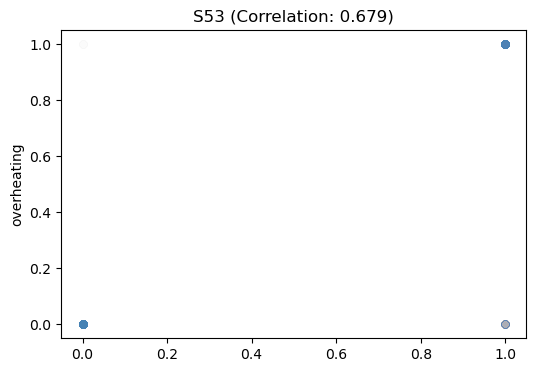

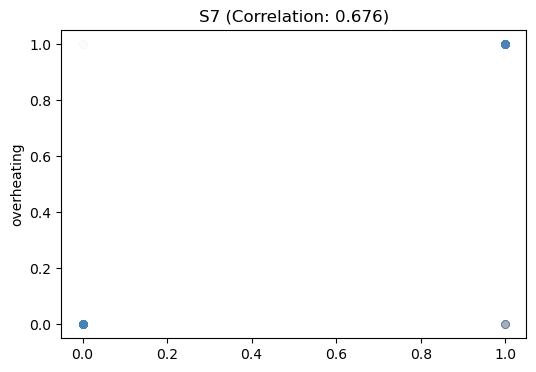

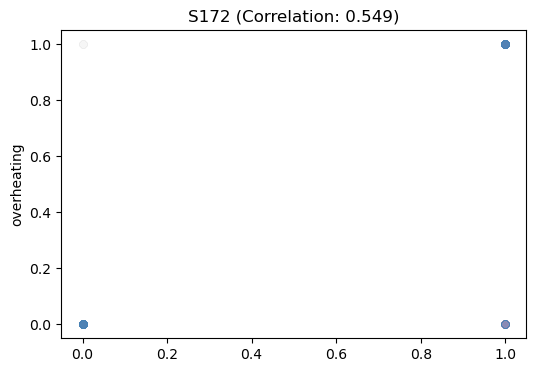

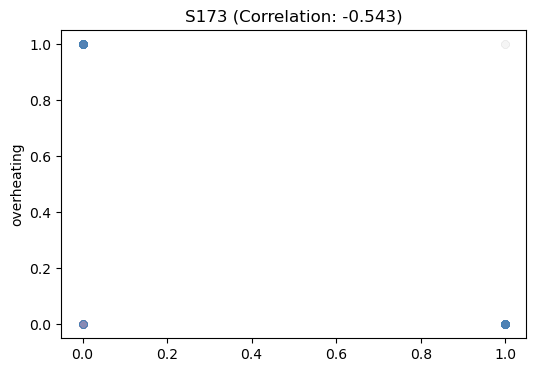

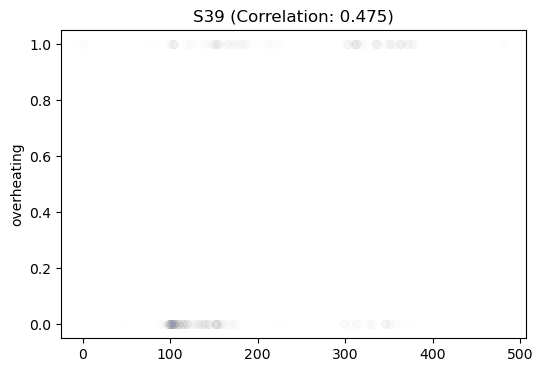

In [44]:
interest = prova_corr_alarm.head(5)["Sensors"].tolist()
plot_scatter_corr( df_filtrato_prova, "overheating", interest, prova_corr_alarm )

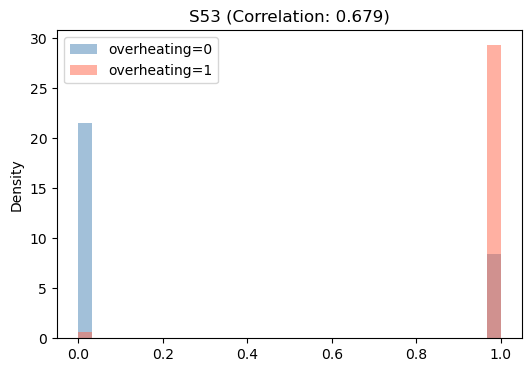

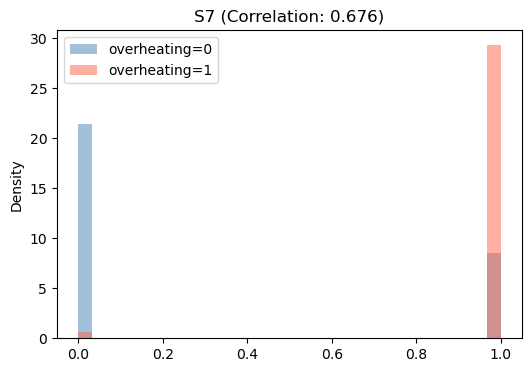

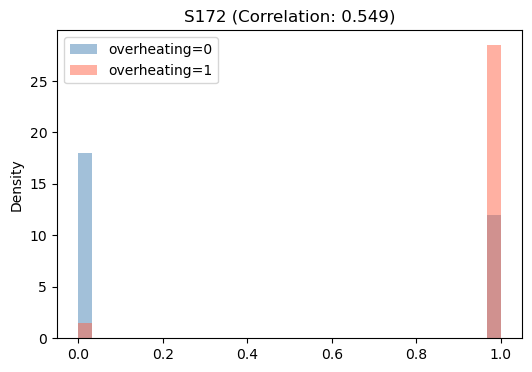

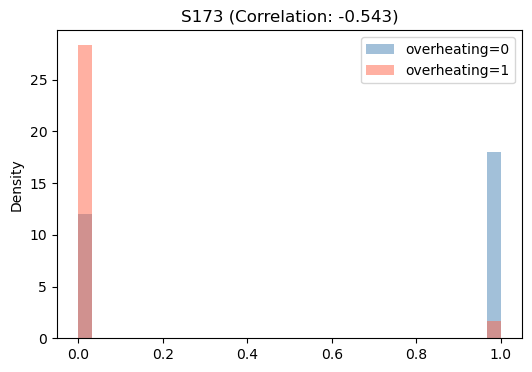

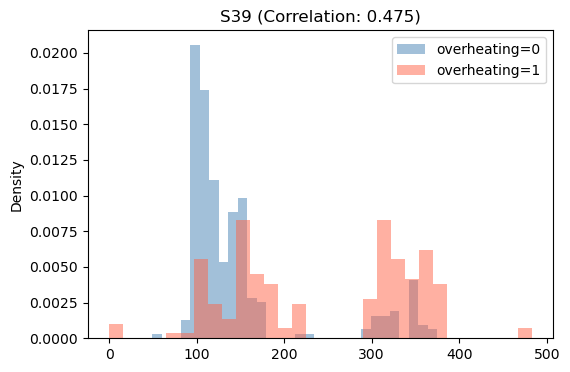

In [45]:
plot_histograms_by_target(df_filtrato_prova, "overheating", interest, prova_corr_alarm)

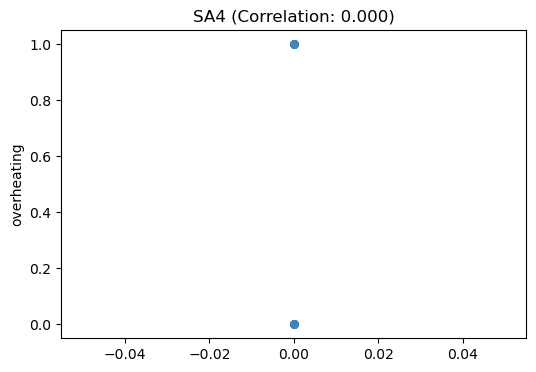

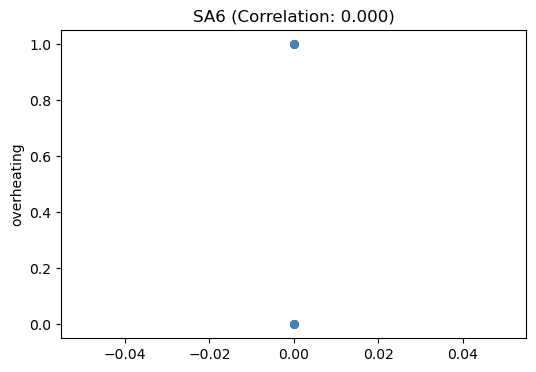

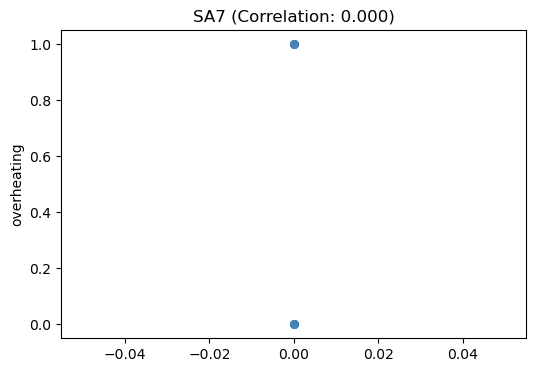

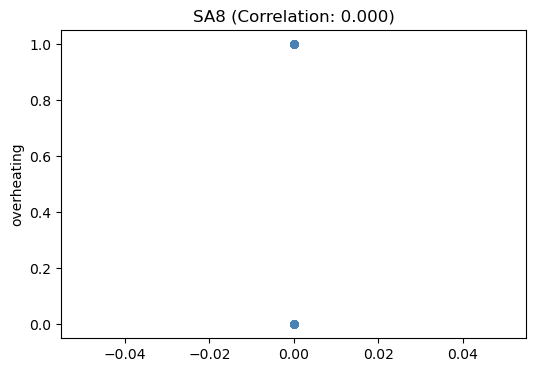

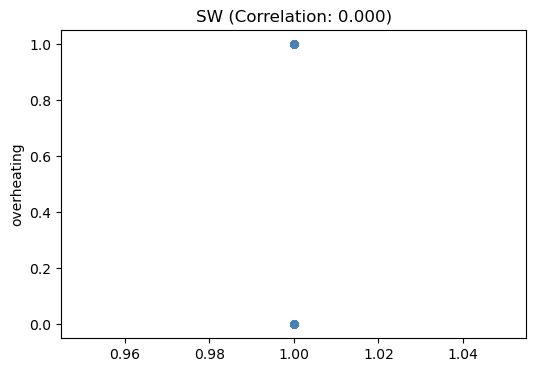

In [46]:
#array_nan = prova_corr_alarm[prova_corr_alarm["correlazioni"].isna()]["sensori"].tolist()

array_nan = prova_corr_alarm.tail(5)["Sensors"].tolist()
plot_scatter_corr( df_filtrato_prova, "overheating", array_nan, prova_corr_alarm )

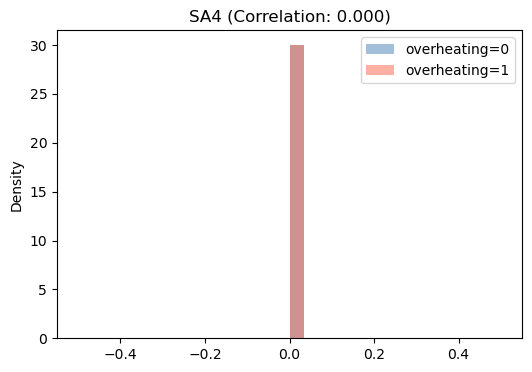

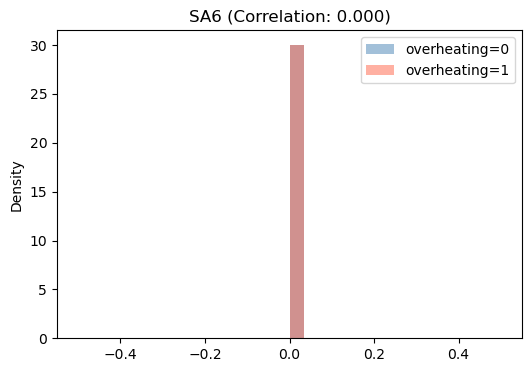

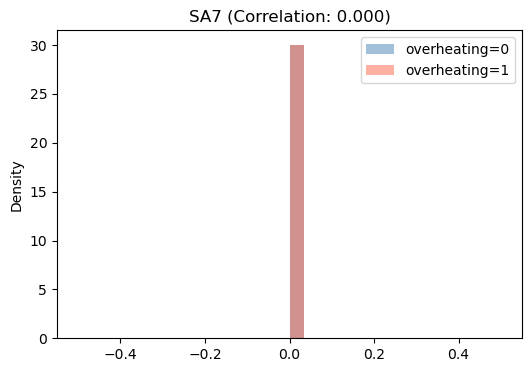

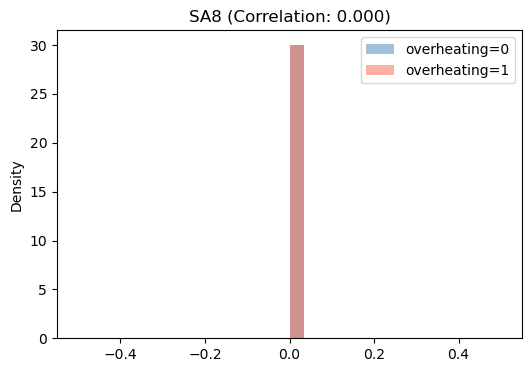

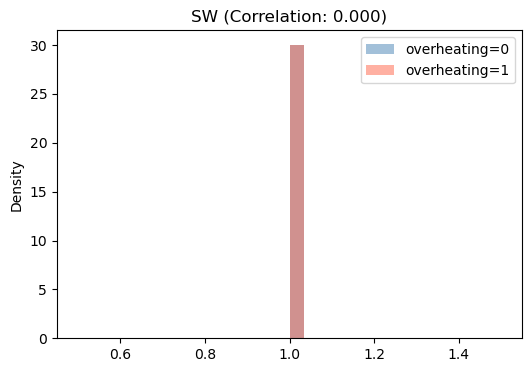

In [47]:
plot_histograms_by_target(df_filtrato_prova, "overheating", array_nan, prova_corr_alarm)

# Predictive Maintenance

# <hr style="height:4px; background-color:black; border:none;" />

#  Vecchio anomaly detect

In [ ]:
def plot_anomaly_hist(df, sensors, time_start, time_end):
    '''
    Plotta il numero di anomalie al giorno per ogni sensore, nell'arco di tempo [time_start, time_end]
    '''

    casts = [col(f'{s}_anomaly').cast('Int') for s in sensors] # per convertire i booleani in mode_S_anomaly in 0/1 
    aggs = [spark_sum(col(f'{s}_anomaly')).alias(f'anomaly_count_{s}') for s in sensors] # per contare le anomalie ogni giorno

    new_df = df \
    .select('window_start', *[f"{s}_anomaly" for s in sensors]) \
    .filter(unix_timestamp(col("window_start")).between(time_start, time_end)) \
    .withColumn('day', to_date(col('window_start'))) \
    .withColumns(dict(zip([f'{s}_anomaly' for s in sensors], casts))) \
    .groupBy('day').agg(*aggs) \
    .orderBy('day')

    n_sensors = len(sensors)
    fig, axes = plt.subplots(ceil(n_sensors/2), 2, figsize=(20, 5))
    days = new_df.select('day').rdd.flatMap(lambda x: x).collect()
    for i in range(n_sensors):
        counts = new_df.select(f'anomaly_count_{sensors[i]}').rdd.flatMap(lambda x: x).collect()
        idx = i if n_sensors <= 2 else (i//2, i%2)
        axes[idx].bar(days, counts)
        axes[idx].set_title(f'anomaly_count_{sensors[i]}')
        axes[idx].set(xlabel="day", ylabel="counts")
        #print(sensors[i], counts)
    fig.tight_layout()

In [ ]:
def detect_switch_anomalies(df, sensors, window_minutes=10, switch_threshold=5):
    """
    Detects frequent switching for binary sensors, partitioned by day to avoid single-node pressure.
    """

    # Extract day (or hour) from timestamp to partition
    df = df.withColumn("day", to_date(col('window_start')))

    # Lag to get previous value within each partition --- OTHERWISE IT MOVES ALL IN THE SAME PARTITION
    w_lag = Window.partitionBy("day").orderBy("when")
    lagged_columns = [lag(col(s)).over(w_lag) for s in sensors] # per ogni sensore prendo le righe shiftate di 1 all'indietro
    lag_names      = [f"lagged_{s}" for s in sensors]
    
    df_lagged = df.withColumns(dict(zip(lag_names, lagged_columns)))

    # Detect change 0→1 or 1→0
    didSwitch   = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] # per ogni sensore verifico se il valore è cambiato rispetto al precedente 
    switch_names = [f"switch_{s}" for s in sensors]
    
    df_changes = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Rolling window over time with partition
    w_time = Window.partitionBy("day").orderBy("when").rangeBetween(-window_minutes * 60, 0)
    change_counts = [spark_sum(f"switch_{s}").over(w_time) for s in sensors]
    counts_names  = [f"change_count_{s}" for s in sensors]
    
    df_windowed = df_changes.withColumns(dict(zip(counts_names, change_counts)))

    # Flag anomaly
    anomalies       = [col(f"change_count_{s}") > switch_threshold for s in sensors]
    anomalies_names = [f"{s}_anomaly" for s in sensors]
    
    df_anomaly = df_windowed \
    .withColumns(dict(zip(anomalies_names, anomalies))) \
    .select("BlockID","window_id","window_start",*sensors,*anomalies_names)
    #.drop(*lag_names, *switch_names, *counts_names, "day", "when")

    return df_anomaly

In [ ]:
%%time

sensors = ['S117', 'S118', 'S169', 'S170']

anomalies = detect_switch_anomalies(
  df_final,
  sensors=[s for s in sensors],
  window_minutes=60,
  switch_threshold=6
)

# Almeno un motore abbia anomalia per dire di aver anomalia
anomalies = anomalies.withColumn(
    "has_anomaly",
    when(
        col("S117_anomaly") | col("S118_anomaly") | col("S169_anomaly") | col("S170_anomaly"),
        1
    ).otherwise(0)
)

# Per confronto vediamo se le anomalie del S117 corrispondono a quelle del metodo di Marco:
anomalies \
    .filter("S117_anomaly") \
    .show(100, truncate=False)

# Questo non va ancora
#filters = [col(f"mode_{s}_anomaly") for s in sensors] 
#total_filter = filters[0]
#for i in range(1, len(filters)):
#    total_filter = total_filter & filters[i]


[Stage 1610:===================================================>(199 + 1) / 200]

In [106]:
def plot_anomaly_hist(df, sensors, time_start, time_end):
    '''
    Plotta il numero di anomalie al giorno per ogni sensore, nell'arco di tempo [time_start, time_end]
    '''

    casts = [col(f'{s}_anomaly').cast('Int') for s in sensors] # per convertire i booleani in mode_S_anomaly in 0/1 
    aggs = [spark_sum(col(f'{s}_anomaly')).alias(f'anomaly_count_{s}') for s in sensors] # per contare le anomalie ogni giorno

    new_df = df \
    .select('window_start', *[f"{s}_anomaly" for s in sensors]) \
    .filter(unix_timestamp(col("window_start")).between(time_start, time_end)) \
    .withColumn('day', to_date(col('window_start'))) \
    .withColumns(dict(zip([f'{s}_anomaly' for s in sensors], casts))) \
    .groupBy('day').agg(*aggs) \
    .orderBy('day')

    n_sensors = len(sensors)
    fig, axes = plt.subplots(ceil(n_sensors/2), 2, figsize=(20, 5))
    days = new_df.select('day').rdd.flatMap(lambda x: x).collect()
    for i in range(n_sensors):
        counts = new_df.select(f'anomaly_count_{sensors[i]}').rdd.flatMap(lambda x: x).collect()
        idx = i if n_sensors <= 2 else (i//2, i%2)
        axes[idx].bar(days, counts)
        axes[idx].set_title(f'anomaly_count_{sensors[i]}')
        axes[idx].set(xlabel="day", ylabel="counts")
        #print(sensors[i], counts)
    fig.tight_layout()
  

CPU times: user 215 ms, sys: 7.35 ms, total: 223 ms
Wall time: 5.24 s


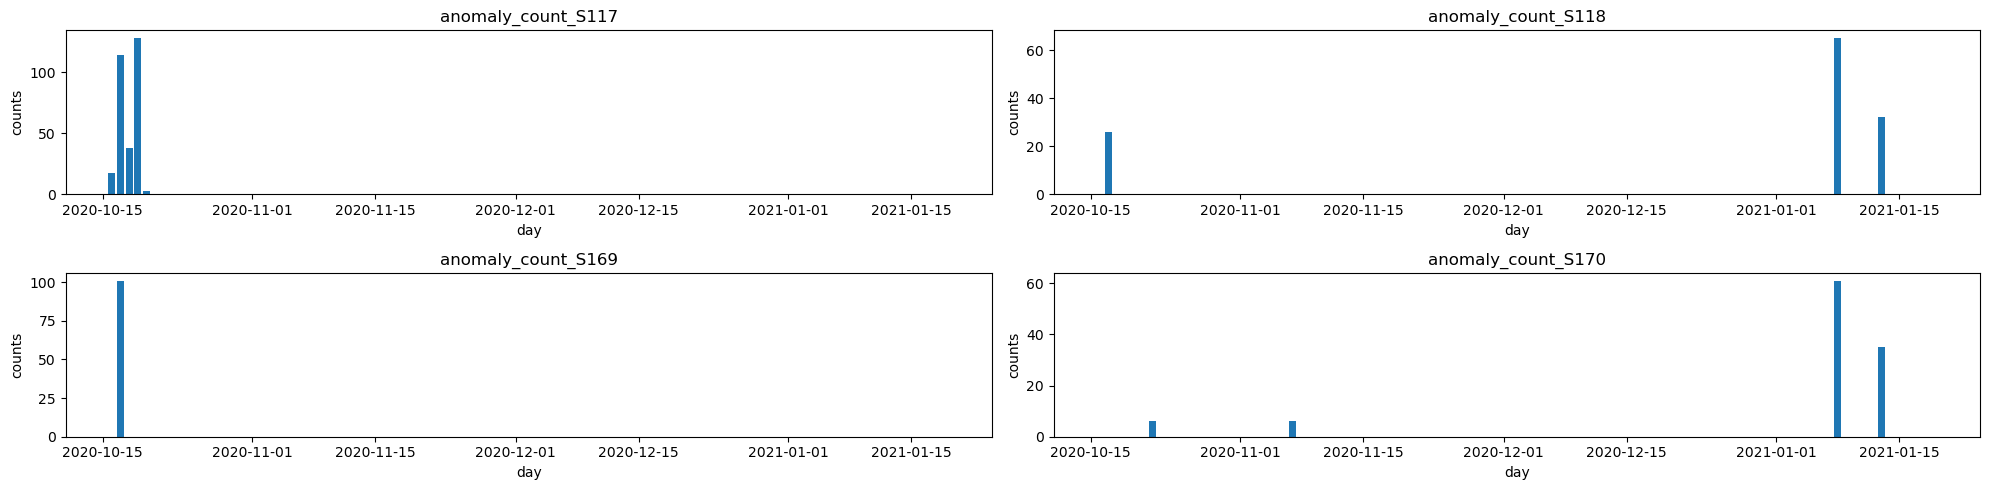

In [45]:
%%time
plot_anomaly_hist(anomalies, ['S117', 'S118', 'S169', 'S170'], 1602879000, 1602879000+10000000)  

# Correlations(vecchia versione---vedere di recuperare ROC magari)

In [ ]:
from pyspark.sql.functions import approx_count_distinct

def ChangingMetrics(df, BlockID, minCounts=10):
    
    excluded_cols = {"window_id", "when", "window_start", "window_end", "ComError", 
                     "Prev_TimeStamp", "TimeDiff_s", "CheckNewBlock", "BlockID"}

    block_df = df.filter(col("BlockID") == BlockID)
    
    #Estimates the approximate distinct count of elements in a specified column
    agg_exprs = [approx_count_distinct(c).alias(c)for c in block_df.columns if c not in excluded_cols]

    #Parallelized count of the groups
    counts = block_df.agg(*agg_exprs).collect()[0].asDict()
    return [col_name for col_name, count in counts.items() if count > minCounts]

In [42]:
%%time

Metric118 = ChangingMetrics(df_final, BlockID=118)
Metric119 = ChangingMetrics(df_final, BlockID=119)

In [25]:
print(Metric118)

['S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S122', 'S124', 'S126', 'S128', 'S129', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S178', 'S180', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S71', 'S72', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97']


In [26]:
#is needed a function to retrieve all the blocks that presents anomalies 
#For now, dummy selection:

PandaDF = df_final.toPandas()

Anom = PandaDF[PandaDF['BlockID'] == 119]
Norm = PandaDF[PandaDF['BlockID'] == 118]

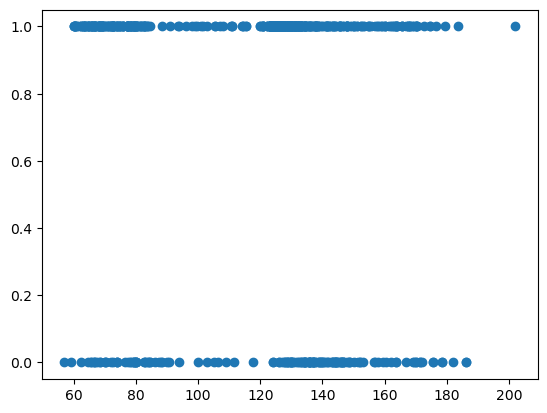

In [27]:
Complete = pd.concat([Norm, Anom])

HasAnom118 = np.zeros(len(Norm))
HasAnom119 = np.ones(len(Anom))
HasAnom = np.concatenate([HasAnom118, HasAnom119])

P10 = Complete['S101']

plt.scatter(P10, HasAnom

In [43]:
from sklearn.metrics import roc_auc_score

score = roc_auc_score(HasAnom, P10)

# Various checks to show that everything works (questi li terrei)

In [20]:
# inspect a specific region
start_ts = 1601526622
end_ts   = 1601531000

df_resampled_S117.filter(
    (col("when") >= start_ts) & 
    (col("when") <= end_ts)
).show()

25/07/30 07:48:35 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/30 07:49:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/30 07:49:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
                                                                                

+----------+----+-------------------+
|      when|S117|               time|
+----------+----+-------------------+
|1601526622|   0|2020-10-01 04:30:22|
|1601526682|   0|2020-10-01 04:31:22|
|1601526742|   0|2020-10-01 04:32:22|
|1601526862|   0|2020-10-01 04:34:22|
|1601526922|   0|2020-10-01 04:35:22|
|1601526982|   0|2020-10-01 04:36:22|
|1601527042|   0|2020-10-01 04:37:22|
|1601527102|   0|2020-10-01 04:38:22|
|1601527162|   0|2020-10-01 04:39:22|
|1601527222|   0|2020-10-01 04:40:22|
|1601529262|   0|2020-10-01 05:14:22|
|1601529322|   0|2020-10-01 05:15:22|
|1601529382|   0|2020-10-01 05:16:22|
|1601529442|   0|2020-10-01 05:17:22|
|1601529502|   0|2020-10-01 05:18:22|
|1601529562|   0|2020-10-01 05:19:22|
|1601529622|   0|2020-10-01 05:20:22|
|1601529682|   0|2020-10-01 05:21:22|
|1601529742|   0|2020-10-01 05:22:22|
|1601529802|   0|2020-10-01 05:23:22|
+----------+----+-------------------+
only showing top 20 rows



In [22]:
inspect(df_hard, sensors=["S117"], start=1601526622, end=1601531000).show()

[Stage 70:>                                                         (0 + 3) / 4]

+-------------------+----------+----+
|               time|      when|S117|
+-------------------+----------+----+
|2020-10-01 04:30:32|1601526632|   0|
|2020-10-01 04:30:39|1601526639|NULL|
|2020-10-01 04:31:02|1601526662|   0|
|2020-10-01 04:31:05|1601526665|NULL|
|2020-10-01 04:31:33|1601526693|   0|
|2020-10-01 04:31:35|1601526695|NULL|
|2020-10-01 04:32:03|1601526723|   0|
|2020-10-01 04:34:10|1601526850|   0|
|2020-10-01 04:34:13|1601526853|NULL|
|2020-10-01 04:34:41|1601526881|   0|
|2020-10-01 04:34:43|1601526883|NULL|
|2020-10-01 04:35:11|1601526911|   0|
|2020-10-01 04:35:14|1601526914|NULL|
|2020-10-01 04:35:41|1601526941|   0|
|2020-10-01 04:35:45|1601526945|NULL|
|2020-10-01 04:36:11|1601526971|   0|
|2020-10-01 04:36:19|1601526979|NULL|
|2020-10-01 04:36:42|1601527002|   0|
|2020-10-01 04:36:45|1601527005|NULL|
|2020-10-01 04:37:12|1601527032|   0|
+-------------------+----------+----+
only showing top 20 rows



In [29]:
inspect(df_hard, sensors=["S117"], start=1601527100, end=1601529400).show()

[Stage 131:====================================================>  (37 + 2) / 39]

+-------------------+----------+----+
|               time|      when|S117|
+-------------------+----------+----+
|2020-10-01 04:38:23|1601527103|NULL|
|2020-10-01 04:38:43|1601527123|   0|
|2020-10-01 04:38:46|1601527126|NULL|
|2020-10-01 04:39:14|1601527154|   0|
|2020-10-01 04:39:17|1601527157|NULL|
|2020-10-01 04:39:44|1601527184|   0|
|2020-10-01 04:39:47|1601527187|NULL|
|2020-10-01 04:40:14|1601527214|   0|
|2020-10-01 04:40:17|1601527217|NULL|
|2020-10-01 04:40:45|1601527245|   0|
|2020-10-01 05:14:00|1601529240|   0|
|2020-10-01 05:14:03|1601529243|NULL|
|2020-10-01 05:14:31|1601529271|   0|
|2020-10-01 05:14:33|1601529273|NULL|
|2020-10-01 05:15:01|1601529301|   0|
|2020-10-01 05:15:04|1601529304|NULL|
|2020-10-01 05:15:31|1601529331|   0|
|2020-10-01 05:15:34|1601529334|NULL|
|2020-10-01 05:16:02|1601529362|   0|
|2020-10-01 05:16:04|1601529364|NULL|
+-------------------+----------+----+
only showing top 20 rows



In [30]:
# Check everything is fine

# Compute time differences
rdd_diff_S117 = compute_time_differences(df_resampled_S117)

# Summarize and print top/bottom time gaps
df_diff_summary_S117 = time_diff_summary(rdd_diff_S117, spark)

25/07/29 13:19:01 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 13:19:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:19:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:19:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:19:36 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
                                                                                

Number of time differences: 105888

5 smallest time differences:
+----+-----+
|diff|count|
+----+-----+
|60  |98162|
|120 |4869 |
|180 |2168 |
|240 |283  |
|300 |131  |
+----+-----+
only showing top 5 rows


5 largest time differences:
+-------+-----+
|diff   |count|
+-------+-----+
|5003760|1    |
|2066880|1    |
|757860 |1    |
|51960  |1    |
|28620  |1    |
+-------+-----+
only showing top 5 rows



In [31]:
# questo dai dati di prima, sembra funzionare
# |5003774|1    |
# |2066908|1    |
# |757864 |1    |
# |48451  |1    |
# |28598  |1    |

In [42]:
def count_contiguous_blocks(
    df: DataFrame,
    interval: int,
    col_when: str = "when"
) -> DataFrame:
    """
    Count contiguous blocks of rows spaced exactly `interval` seconds apart,
    partitioned by day for parallelism.

    Args:
      df:         Spark DataFrame with a timestamp column in seconds.
      interval:   Expected spacing between consecutive rows (in seconds).
      col_when:   Name of that timestamp column (default 'when').

    Returns:
      DataFrame with columns:
        - block_length: number of rows in each contiguous block
        - block_count:  how many such blocks exist
    """
    # 1) Add a 'day' column for partitioning
    df2 = df.withColumn("day", to_date(from_unixtime(col(col_when))))

    # 2) Window over each day, ordered by timestamp
    w = Window.partitionBy("day").orderBy(col(col_when))

    # 3) Compute the gap to the previous timestamp
    df3 = (
        df2
        .withColumn("prev_when", lag(col(col_when), 1).over(w))
        .withColumn("gap", col(col_when) - col("prev_when"))
    )

    # 4) Flag start of new block when gap != interval (or first in day)
    df4 = df3.withColumn(
        "is_new_block",
        expr(f"CASE WHEN gap IS NULL OR gap != {interval} THEN 1 ELSE 0 END")
    )

    # 5) Cumulative sum over the window to assign a block_id
    df5 = df4.withColumn(
        "block_id",
        spark_sum(col("is_new_block")).over(w)
    )

    # 6) Count rows per (day, block_id) → this is block_length
    blocks = (
        df5
        .groupBy("day", "block_id")
        .agg(count("*").alias("block_length"))
    )

    # 7) Count how many blocks have each length across all days
    result = (
        blocks
        .groupBy("block_length")
        .agg(count("*").alias("block_count"))
        .orderBy("block_length")
    )

    return result

In [43]:
def plot_diff_histogram(df_block_stats, min_length=1, max_length=100, step=1):
    """
    Plot a histogram of contiguous block lengths.

    Args:
      df_block_stats: Spark DataFrame with ['block_length','block_count']
      min_length:     smallest block_length to include
      max_length:     largest block_length to include
      step:           bar width
    """
    pdf = (
        df_block_stats
        .filter((col("block_length") >= min_length) &
                (col("block_length") <= max_length))
        .orderBy("block_length")
        .toPandas()
    )

    if pdf.empty:
        print("No blocks in the specified range.")
        return

    plt.figure(figsize=(10,5))
    plt.bar(pdf["block_length"], pdf["block_count"], width=step, align="center")
    plt.xlabel("Block Length")
    plt.ylabel("Number of Blocks")
    plt.title("Histogram of Contiguous Block Lengths")
    plt.grid(True)
    plt.xlim(min_length, max_length)
    plt.show()

In [44]:
# 1) Select only the timestamp column
df_sample = df_resampled_S117.select("when")

# 2) Compute contiguous block stats at 60s spacing
block_stats = count_contiguous_blocks(df_sample, interval=60)

# 3) Inspect
block_stats.show()

NameError: name 'df_resampled_S117' is not defined

25/07/29 13:21:37 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 13:21:56 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


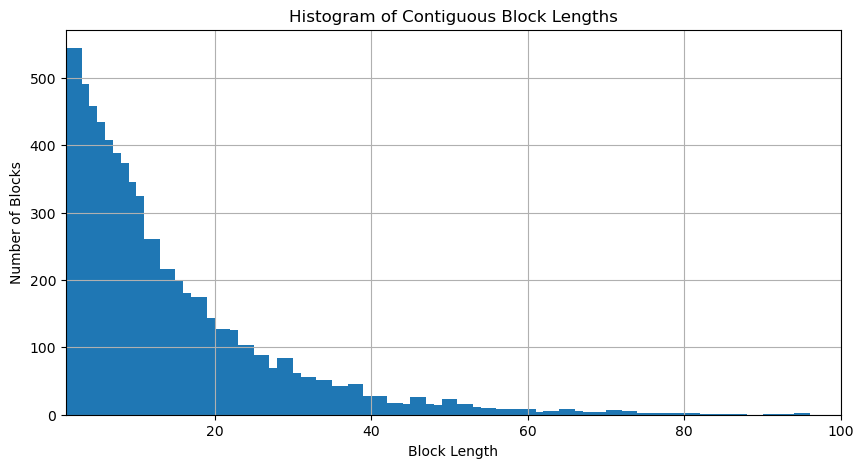

In [39]:
# 4) Plot histogram for blocks length 1–1000
plot_diff_histogram(block_stats, min_length=1, max_length=100, step=2)

In [52]:
def resample_sensor(
    df_hard: DataFrame,
    sensor: str,
    interval: int = 60,
    method: str = "near"
) -> DataFrame:
    """
    Resample a single sensor column to regular intervals.

    Args:
      df_hard:   DataFrame with 'when' (in seconds) and the sensor column.
      sensor:    name of the sensor column (e.g. 'S117').
      interval:  interval in seconds (e.g. 60).
      method:    one of 'near', 'min', 'max', 'mean'.

    Returns:
      DataFrame with columns ['when', sensor, 'time'] at regular timestamps.
      All values are non-null. If no data is found for a window, the row is skipped.
    """
    spark = df_hard.sparkSession
    half = interval / 2

    # Validate method
    if method not in ("near", "min", "max", "mean"):
        raise ValueError(f"Unsupported method '{method}'. Choose from 'near', 'min', 'max', 'mean'.")

    # 1. Create time grid
    bounds = df_hard.selectExpr("min(when) as min_t", "max(when) as max_t").first()
    min_t, max_t = bounds.min_t, bounds.max_t

    grid_df = (
        spark.range(1)
             .selectExpr(f"sequence({min_t}, {max_t}, {interval}) as times")
             .select(explode("times").alias("target_when"))
    )

    # 2. Join with range ± half interval and exclude NULLs before aggregation
    filtered = df_hard.select("when", sensor).filter(col(sensor).isNotNull())

    joined = (
        filtered
          .join(
              grid_df,
              (col("when") >= col("target_when") - half) &
              (col("when") <= col("target_when") + half),
              how="inner"
          )
          .withColumn("time_diff", spark_abs(col("when") - col("target_when")))
    )

    # 3. Aggregate based on method
    if method == "near":
        agg_expr = min_by(col(sensor), col("time_diff")).alias(sensor)
    elif method == "min":
        agg_expr = spark_min(col(sensor)).alias(sensor)
    elif method == "max":
        agg_expr = spark_max(col(sensor)).alias(sensor)
    else:  # mean
        agg_expr = spark_avg(col(sensor)).alias(sensor)

    result = (
        joined.groupBy("target_when")
              .agg(agg_expr)
    )

    # 4. Final formatting
    final = (
        result
          .withColumnRenamed("target_when", "when")
          .withColumn("time", from_unixtime(col("when")))
          .orderBy("when")
    )

    return final

In [106]:
# Nearest‐time fill
df_near = resample_sensor(df_hard, "S117", interval=60, method="near")
df_near.show(5)

# Minimum‐value fill
df_min = resample_sensor(df_hard, "S117", interval=60, method="min")
df_min.show(5)

# Maximum‐value fill
df_max = resample_sensor(df_hard, "S117", interval=60, method="max")
df_max.show(5)

# Mean‐value fill
df_mean = resample_sensor(df_hard, "S117", interval=60, method="mean")
df_mean.show(5)

# Invalid method raises:
# resample_sensor(df_hard, "S117", 60, method="median")
# → ValueError: Unsupported method 'median'. Choose from 'near', 'min', 'max', 'mean'.

In [47]:
# PROVA MARCO VECCHIA CONVERSIONE SENSORI A5 A9, ricopiata il codice può essere utile
# --- OCCHIO --- questo ti pare che faccia la conversione del binario da dx verso sx, dovrebbe essere il contrario

# def convert_a5_to_binary_bits(df,sensor):
#     df_with_bits = df
    
#     for i in range(16):
#         bit_position = 15 - i  # S1 = bit 15 (leftmost), S16 = bit 0 (rightmost)
#         df_with_bits = df_with_bits.withColumn(
#             f"YOLO{i+1}",
#             (  col(sensor).bitwiseAND(1 << bit_position)  > 0 ).cast("int")
#         )
    
#     return df_with_bits

# # Usage
# df_with_binary = convert_a5_to_binary_bits(df_pivoted,"A5")

In [40]:
def detect_switch_anomaly(df, sensor, window_minutes=10, switch_threshold=5):
    """
    Detects frequent switching for binary sensor, partitioned by day to avoid single-node pressure.
    """

    # Extract day (or hour) from timestamp to partition
    df = df.withColumn("day", to_date(from_unixtime(col("when"))))

    # Lag to get previous value within each partition --- OTHERWISE IT MOVES ALL IN THE SAME PARTITION
    w_lag = Window.partitionBy("day").orderBy("when")
    df_lagged = df.withColumn("prev", lag(col(sensor)).over(w_lag))

    # Detect change 0→1 or 1→0
    df_changes = df_lagged.withColumn(
        "change", when((col("prev") != col(sensor)), 1).otherwise(0)
    )

    # Rolling window over time with partition
    w_time = Window.partitionBy("day").orderBy("when").rangeBetween(-window_minutes * 60, 0)
    df_windowed = df_changes.withColumn(
        "change_count", sum_("change").over(w_time)
    )

    # Flag anomaly
    df_anomaly = df_windowed.withColumn(
        "is_anomaly", (col("change_count") > switch_threshold)
    ).drop("prev", "change", "change_count", "day")

    return df_anomaly

In [41]:
df_anom = detect_switch_anomaly(
  df_resampled_S117,
  sensor="S117",
  window_minutes=60,
  switch_threshold=6
)
df_anom.filter("is_anomaly").show()

25/07/29 13:22:17 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 13:22:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/07/29 13:22:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+----------+----+-------------------+----------+
|      when|S117|               time|is_anomaly|
+----------+----+-------------------+----------+
|1602882502|   1|2020-10-16 21:08:22|      true|
|1602882562|   1|2020-10-16 21:09:22|      true|
|1602882622|   1|2020-10-16 21:10:22|      true|
|1602882742|   0|2020-10-16 21:12:22|      true|
|1602882802|   0|2020-10-16 21:13:22|      true|
|1602882862|   0|2020-10-16 21:14:22|      true|
|1602882922|   0|2020-10-16 21:15:22|      true|
|1602932722|   1|2020-10-17 11:05:22|      true|
|1602932782|   1|2020-10-17 11:06:22|      true|
|1602932842|   1|2020-10-17 11:07:22|      true|
|1602932902|   0|2020-10-17 11:08:22|      true|
|1602932962|   0|2020-10-17 11:09:22|      true|
|1602933022|   0|2020-10-17 11:10:22|      true|
|1602933082|   0|2020-10-17 11:11:22|      true|
|1602933142|   0|2020-10-17 11:12:22|      true|
|1602933202|   0|2020-10-17 11:13:22|      true|
|1602933262|   0|2020-10-17 11:14:22|      true|
|1602933322|   0|202

In [42]:
ini = 1602882742-50*60

In [43]:
fine =1602882742+50*60

In [44]:
inspect(df_resampled_S117, sensors=["S117"], start=ini, end=fine).show(100)

25/07/29 13:22:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/29 13:23:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+-------------------+----------+----+
|               time|      when|S117|
+-------------------+----------+----+
|2020-10-16 20:22:22|1602879742|   0|
|2020-10-16 20:23:22|1602879802|   0|
|2020-10-16 20:24:22|1602879862|   0|
|2020-10-16 20:25:22|1602879922|   0|
|2020-10-16 20:26:22|1602879982|   0|
|2020-10-16 20:27:22|1602880042|   0|
|2020-10-16 20:28:22|1602880102|   1|
|2020-10-16 20:29:22|1602880162|   1|
|2020-10-16 20:30:22|1602880222|   1|
|2020-10-16 20:31:22|1602880282|   1|
|2020-10-16 20:32:22|1602880342|   0|
|2020-10-16 20:33:22|1602880402|   0|
|2020-10-16 20:34:22|1602880462|   0|
|2020-10-16 20:35:22|1602880522|   0|
|2020-10-16 20:36:22|1602880582|   0|
|2020-10-16 20:37:22|1602880642|   0|
|2020-10-16 20:38:22|1602880702|   0|
|2020-10-16 20:39:22|1602880762|   0|
|2020-10-16 20:40:22|1602880822|   0|
|2020-10-16 20:41:22|1602880882|   0|
|2020-10-16 20:42:22|1602880942|   0|
|2020-10-16 20:43:22|1602881002|   0|
|2020-10-16 20:44:22|1602881062|   0|
|2020-10-16 

25/07/29 13:23:13 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
                                                                                

# <hr style="height:4px; background-color:black; border:none;" />

# *** Remember to close Spark Session ***

In [60]:
spark.stop()